In [1]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx

import matplotlib.pyplot as plt

In [2]:
# read in the data
edges = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkEdges.csv")
nodes = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkNodes.csv", encoding='unicode_escape', engine ='python')
risks = pd.read_csv("../data/EDIndex20221202.csv")

In [3]:
# make the network
G = nx.from_pandas_edgelist(edges, source='from', target='to', edge_attr = ['l', 'time', 'timeU', 'timeUCB'])

# add the node attributes
nx.set_node_attributes(G, nodes.set_index('Agglomeration_ID').to_dict('index'))

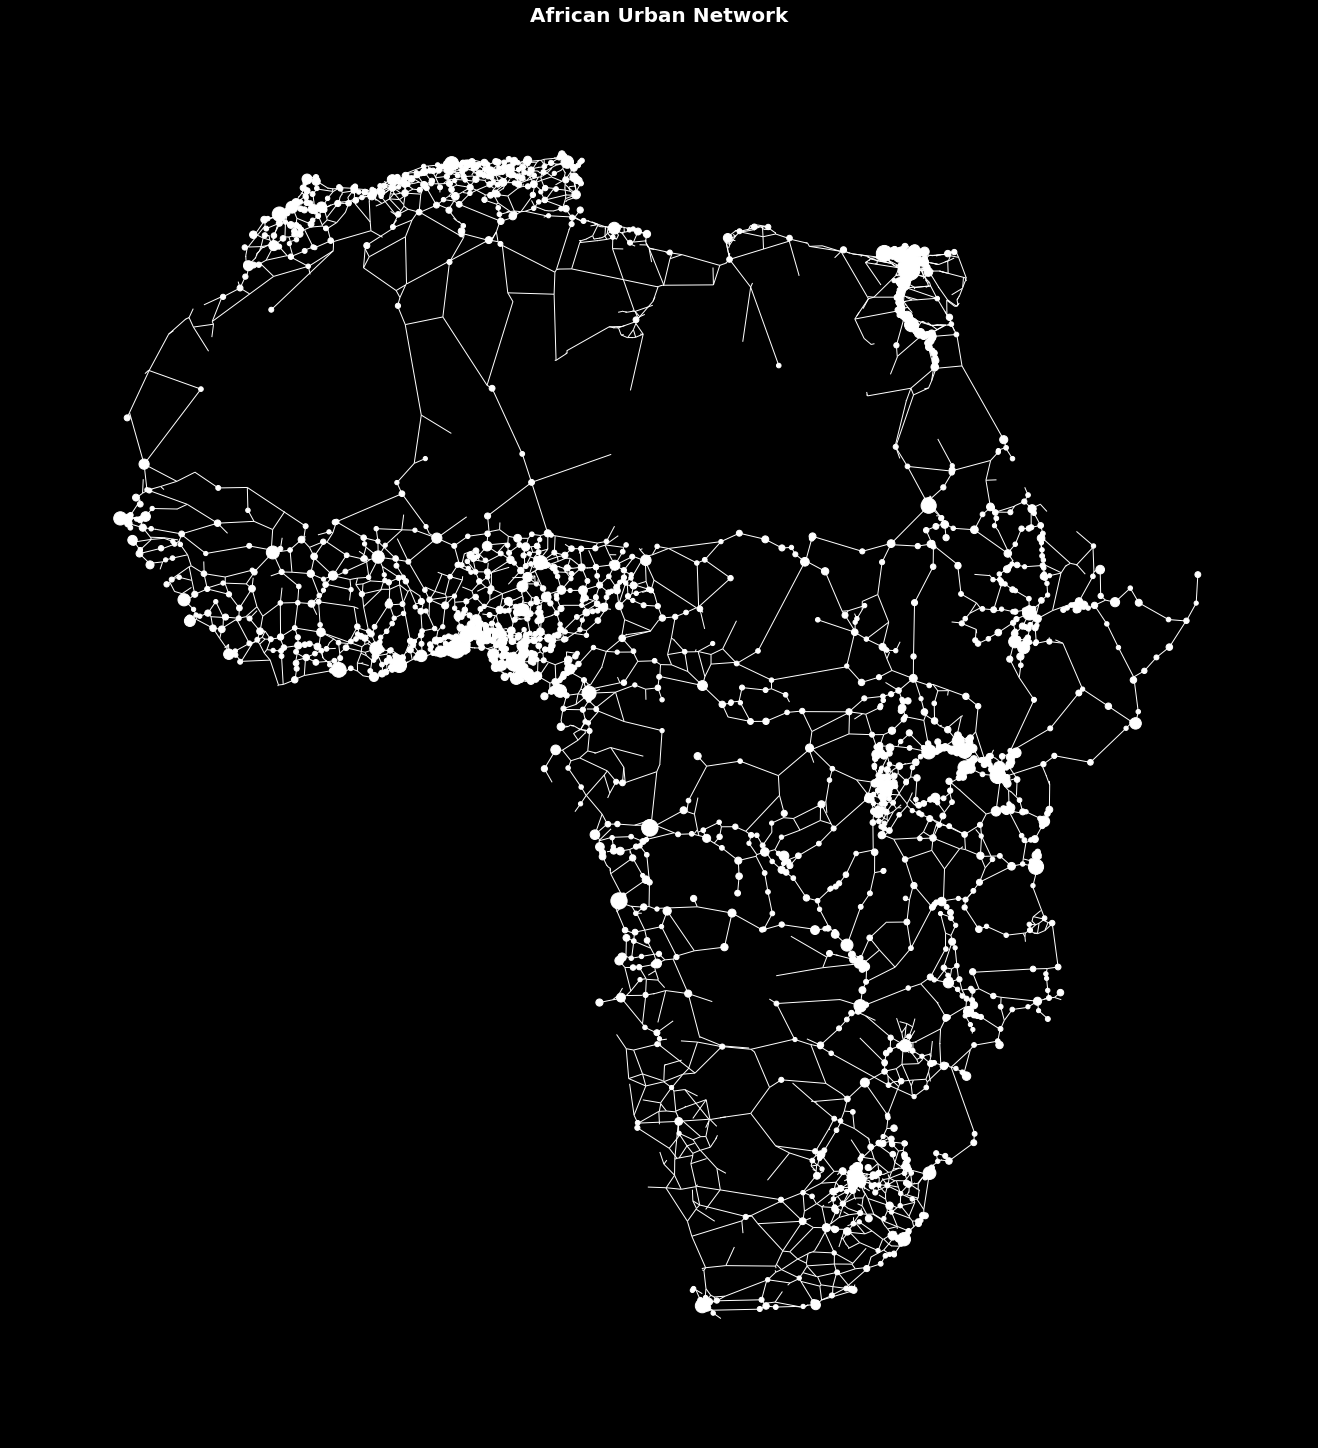

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

position = {n: [d['x'], d['y']] for n, d in G.nodes(data=True)}
size = [np.sqrt(d['Pop2015'] / 100) for n, d in G.nodes(data=True)]

nx.draw_networkx_edges(G, ax=ax, pos=position, edge_color='w', alpha=1)
nx.draw_networkx_nodes(G, ax=ax, pos=position, node_color='w', node_size=size, alpha=1)
ax.set_facecolor('k')

fig.suptitle('African Urban Network', color='w', size=20, weight='bold')
fig.savefig('../viz/africapolis-network.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')  

In [5]:
# compute the weighted distance between nodes using dijkstra's algorithm
# 3500 kilometers is the distance from Lagos to Dakar, the ends of a corridor according to the literature
%time distances = dict(nx.all_pairs_dijkstra_path_length(G, weight='l', cutoff=3500))

CPU times: user 23.1 s, sys: 229 ms, total: 23.4 s
Wall time: 23.4 s


In [6]:
# get the index values for roads, which are labeled as 'road' in the 'agglosName' attribute with the node data
junctions = [n for n, d in G.nodes(data=True) if d['agglosName']=='road']

In [7]:
# how many nodes to we start out with?
len(G.nodes())

7361

In [8]:
# remove entries in the dictionary that are junctions, del for delete
for k in junctions:
    del distances[k]

In [9]:
# check to see that we are down to just the cities
len(distances)

2162

In [10]:
# for each entry in distances, remove the self-loops
for i in distances:
    del distances[i][i]

In [11]:
# convert distances to data frame then melt all columns into a single column
pathlengths = pd.DataFrame(distances).reset_index().melt(id_vars='index', var_name='to', value_name='distance')
pathlengths = pathlengths.reset_index(drop=True).rename(columns={'index':'from'})
pathlengths = pathlengths[pathlengths['from']!=pathlengths['to']].reset_index(drop=True)
pathlengths.head()

from    to  distance
0     5425  8211  0.798800
1  1000559  8211  1.113085
2  1000567  8211  1.314500
3     2333  8211  4.294382
4  1027090  8211  4.532485

In [12]:
nodes = nodes.set_index('Agglomeration_ID')
nodes.head()

agglosName       x       y   Pop2015 ISO3   Region  \
Agglomeration_ID                                                         
2320                     Cairo  31.324  30.130  22995802  EGY    North   
5199                     Lagos   3.316   6.668  11847635  NGA     West   
7098                   Onitsha   6.928   5.815   8530514  NGA     West   
4220              Johannesburg  28.016 -26.050   8314220  ZAF    South   
4858                  Kinshasa  15.293  -4.408   7270000  COD  Central   

                       Between  degree  
Agglomeration_ID                        
2320              6.979617e+07       6  
5199              3.127663e+07       4  
7098              2.110388e+07       6  
4220              3.568974e+07       5  
4858              1.119784e+06       4

In [13]:
# compute a gravity model with population and distance
def gravity(distances, nodes, alpha=1, beta=1):
    # compute the denominator
    denominator = 0
    for i in distances:
        for j in distances[i]:
            denominator += (np.power(distances[i][j], -float(beta)) * nodes.loc[i, 'Pop2015'] * nodes.loc[j, 'Pop2015'])
    
    # compute the gravity model
    gravity = {}
    for i in distances:
        gravity[i] = {}
        for j in distances[i]:
            gravity[i][j] = (np.power(distances[i][j], -float(beta)) * nodes.loc[i, 'Pop2015'] * nodes.loc[j, 'Pop2015']) / denominator
    
    return gravity

# wrap it into a data frame
def flow_dataframe(flows):
    df = pd.DataFrame(flows).reset_index().melt(id_vars='index', var_name='to', value_name='flow')
    df = df.reset_index(drop=True).rename(columns={'index':'from'})
    df = df[df['from']!=df['to']].reset_index(drop=True)
    return df

In [14]:
%time flows = flow_dataframe(gravity(distances, nodes, beta=1.6))

CPU times: user 1min 31s, sys: 133 ms, total: 1min 31s
Wall time: 1min 31s


In [15]:
# these flows sum to 1 and should represent the proportion of total flows in Africa
flows['flow'].sum()

0.9999999999999541

In [16]:
# filter flows out flows that are less than 0 
flows_trimmed = flows[flows['flow']>0].reset_index(drop=True)

In [17]:
# colorcet is a great library for color palettes
import colorcet as cc

In [18]:
# get shortest paths
paths = dict(nx.all_pairs_dijkstra_path(G, weight='l', cutoff=3500))

In [19]:
# convert paths to a dataframe, reset the index and melt the data
paths = pd.DataFrame(paths).reset_index().melt(id_vars='index', var_name='to', value_name='path')
paths = paths.reset_index(drop=True).rename(columns={'index':'from'})

In [20]:
# filter paths that are in the flows dataframe
print(paths.shape)
paths = paths[paths['from'].isin(flows_trimmed['from']) & paths['to'].isin(flows_trimmed['to'])].reset_index(drop=True)
print(paths.shape)

(54184321, 3)
(4674244, 3)


In [21]:
# merge paths and flows
paths = paths.merge(flows_trimmed, on=['from', 'to'], how='left')

In [22]:
# remove self loops
paths = paths[paths['from']!=paths['to']].reset_index(drop=True)
# remove nan values
paths = paths[paths['path'].notnull()].reset_index(drop=True)
paths.head()

from    to                         path          flow
0  2333  8211                 [8211, 2333]  8.823502e-05
1  5425  8211                 [8211, 5425]  1.258136e-05
2  8208  8211                 [8211, 8208]  7.249173e-07
3  3833  8211           [8211, 2333, 3833]  3.211520e-07
4  1364  8211  [8211, 2333, 1068481, 1364]  1.252663e-07

In [23]:
# map over paths to get pairs in a moving window
def get_pairs(path):
    pairs = []
    for i in range(len(path)-1):
        pairs.append((path[i], path[i+1]))
    return pairs

# map over paths to get pairs in a moving window
paths['pairs'] = paths['path'].map(get_pairs)

In [24]:
# expand pairs column so that each element of the list becomes a row
paths = paths.explode('pairs').reset_index(drop=True)

# rename from, to columns into origin and destination
paths = paths.rename(columns={'from':'origin', 'to':'destination'})

# split pairs into from and to columns
paths[['from', 'to']] = pd.DataFrame(paths['pairs'].tolist(), index=paths.index)
paths.head()

origin destination                path          flow         pairs  from  \
0    2333        8211        [8211, 2333]  8.823502e-05  (8211, 2333)  8211   
1    5425        8211        [8211, 5425]  1.258136e-05  (8211, 5425)  8211   
2    8208        8211        [8211, 8208]  7.249173e-07  (8211, 8208)  8211   
3    3833        8211  [8211, 2333, 3833]  3.211520e-07  (8211, 2333)  8211   
4    3833        8211  [8211, 2333, 3833]  3.211520e-07  (2333, 3833)  2333   

     to  
0  2333  
1  5425  
2  8208  
3  2333  
4  3833

In [27]:
paths = paths.drop(columns=['flow'])
# join the paths with the flows dataframe
flows_imputed = paths.merge(flows_trimmed, left_on=['origin', 'destination'], right_on=['from', 'to'], how='left')

# rename from_x and to_x columns into from and to
flows_imputed = flows_imputed.rename(columns={'from_x':'from', 'to_x':'to'})

# select from, to, flow, flow_delayed, flow_reduced columns
flows_imputed = flows_imputed[['from', 'to', 'flow']]

# group by from, to and sum the flows
flows_imputed = flows_imputed.groupby(['from', 'to'], as_index=False).sum()

Text(0.5, 1.0, 'Spatial Interaction in Africa')

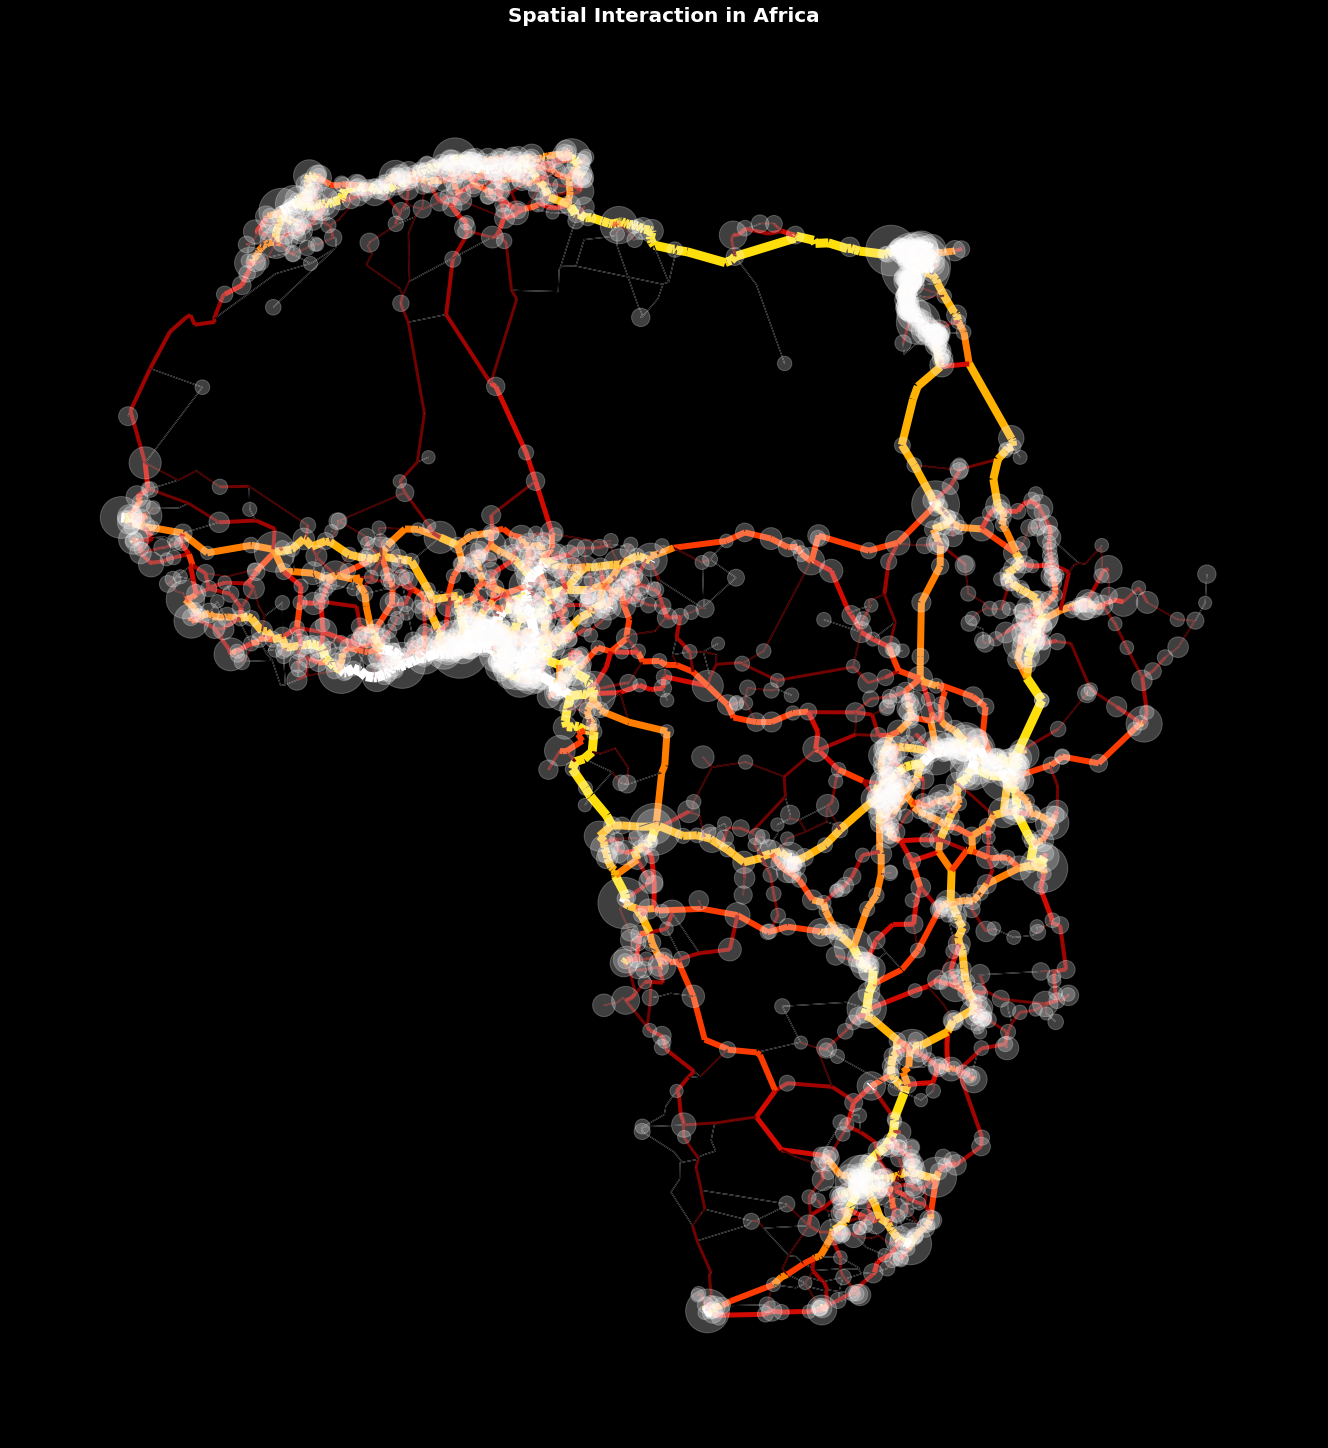

In [28]:
# create a networkx graph from the flows_imputed dataframe
G_imputed = nx.from_pandas_edgelist(flows_imputed, source='from', target='to', edge_attr=['flow'])

# add node attributes
nx.set_node_attributes(G_imputed, nodes.to_dict('index'))

# plot the network
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

# set the node positions
pos = dict(zip(list(G_imputed.nodes()), [[v['x'], v['y']] for k, v in G_imputed.nodes(data=True)]))

# set the node size
node_size = [d['Pop2015'] for k, d in G_imputed.nodes(data=True)]

# draw the nodes
nx.draw_networkx_nodes(G_imputed, pos=pos, node_size=np.sqrt(node_size), node_color='w', alpha=0.25, ax=ax)

# get edge colors
edge_color = [d['flow'] for u, v, d in G_imputed.edges(data=True)]

# break it up into quantiles
edge_color = pd.qcut(edge_color, 10, labels=False)

# draw the edges colored by the flow
nx.draw_networkx_edges(G_imputed, pos=pos, edge_color='w', width=1, ax=ax)
nx.draw_networkx_edges(G_imputed, pos=pos, edge_color=edge_color, width=edge_color + 1, ax=ax, edge_cmap=cc.cm.fire)

# set axis to black
ax.set_facecolor('k')

# turn axis off
ax.set_axis_off()

# set the title
ax.set_title('Spatial Interaction in Africa', color='w', fontsize=20, fontweight='bold')

# save the figure
# plt.savefig('africaspint.png', dpi=300, facecolor='k', bbox_inches='tight')

In [29]:
# this script just checks to make sure that lines not present in the plot are still in the data, just with low values that must be getting filtered out
from shapely.geometry import Point, LineString

# convert nodes to a dataframe
nl = pd.DataFrame.from_dict(dict(G_imputed.nodes(data=True)), orient='index').reset_index().rename(columns={'index':'Agglomeration_ID', 'Region':'region'})
# convert x, y to geometry
nl['geometry'] = nl.apply(lambda x: Point(x['x'], x['y']), axis=1)
# convert to geodataframe
nl = gpd.GeoDataFrame(nl, geometry='geometry')
nl = nl[['Agglomeration_ID', 'region', 'geometry']]

# convert edges to a dataframe
el = nx.to_pandas_edgelist(G_imputed)

# merge the nodes with the edges
el = el.merge(nl, left_on='source', right_on='Agglomeration_ID', how='left').rename(columns={'geometry':'from_geometry', 'region':'from_region'})
el = el.merge(nl, left_on='target', right_on='Agglomeration_ID', how='left').rename(columns={'geometry':'to_geometry', 'region':'to_region'})

# convert the two points to a single line
el['geometry'] = el.apply(lambda x: LineString([x['from_geometry'], x['to_geometry']]), axis=1)

# convert to geodataframe
el = gpd.GeoDataFrame(el, geometry='geometry', crs='epsg:4326')
el = el[['source', 'target', 'flow', 'geometry', 'from_region', 'to_region']]

# el.explore()
el.head()


/Users/asr/opt/anaconda3/envs/locomizer/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/asr/opt/anaconda3/envs/locomizer/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


source   target      flow  \
0       1     1230  0.000094   
1       1     1891  0.001065   
2       1     2320  0.009511   
3       1  1002523  0.000004   
4       1  1046839  0.000026   

                                            geometry from_region to_region  
0  LINESTRING (31.74100 30.28800, 31.45600 30.34300)       North     North  
1  LINESTRING (31.74100 30.28800, 31.55000 30.40500)       North     North  
2  LINESTRING (31.74100 30.28800, 31.32400 30.13000)       North     North  
3  LINESTRING (31.74100 30.28800, 31.90830 29.78073)       North     North  
4  LINESTRING (31.74100 30.28800, 31.86811 30.09149)       North     North

In [30]:
el['crossing'] = el['from_region'] != el['to_region']

In [31]:
region = []

for row in el.iterrows():
    if row[1]['crossing']: 
        region = np.append(region, "crossing")
    else: 
        region = np.append(region, row[1]['from_region'])

In [32]:
el['region'] = region
el.head()

source   target      flow  \
0       1     1230  0.000094   
1       1     1891  0.001065   
2       1     2320  0.009511   
3       1  1002523  0.000004   
4       1  1046839  0.000026   

                                            geometry from_region to_region  \
0  LINESTRING (31.74100 30.28800, 31.45600 30.34300)       North     North   
1  LINESTRING (31.74100 30.28800, 31.55000 30.40500)       North     North   
2  LINESTRING (31.74100 30.28800, 31.32400 30.13000)       North     North   
3  LINESTRING (31.74100 30.28800, 31.90830 29.78073)       North     North   
4  LINESTRING (31.74100 30.28800, 31.86811 30.09149)       North     North   

   crossing region  
0     False  North  
1     False  North  
2     False  North  
3     False  North  
4     False  North

In [33]:
joined = el.merge(risks, left_on=['source', 'target'], right_on=['from', 'to'], how='left')
joined = joined[['source', 'target', 'flow', 'region', 'index', 'geometry']].rename(columns={'index':'risk'})
joined = joined.fillna(0)
joined.head()

source   target      flow region      risk  \
0       1     1230  0.000094  North  2.577277   
1       1     1891  0.001065  North  1.922548   
2       1     2320  0.009511  North  0.000000   
3       1  1002523  0.000004  North  1.286221   
4       1  1046839  0.000026  North  1.288002   

                                            geometry  
0  LINESTRING (31.74100 30.28800, 31.45600 30.34300)  
1  LINESTRING (31.74100 30.28800, 31.55000 30.40500)  
2  LINESTRING (31.74100 30.28800, 31.32400 30.13000)  
3  LINESTRING (31.74100 30.28800, 31.90830 29.78073)  
4  LINESTRING (31.74100 30.28800, 31.86811 30.09149)

In [34]:
# crosswalk = pd.DataFrame({'region': np.unique(region),
#                           'color': np.random.choice(cc.palette['glasbey_light'], len(np.unique(region)))})

# joined = joined.merge(crosswalk, left_on='region', right_on='region', how='left')

In [419]:
joined = joined.drop(columns=['color'])
crosswalk = {
    'region': ['Central', 'East', 'North', 'South', 'West', 'crossing'],
    'color': ['#a0e491', '#48ffef', '#ef72aa', '#953f1f', '#00cff9', '#7c7c7c']
}

crosswalk = pd.DataFrame(crosswalk)

joined = joined.merge(crosswalk, left_on='region', right_on='region', how='left')
joined.head()

source   target      flow region      risk  \
0       1     1230  0.000094  North  2.577277   
1       1     1891  0.001065  North  1.922548   
2       1     2320  0.009511  North  0.000000   
3       1  1002523  0.000004  North  1.286221   
4       1  1046839  0.000026  North  1.288002   

                                            geometry    color  
0  LINESTRING (31.74100 30.28800, 31.45600 30.34300)  #ef72aa  
1  LINESTRING (31.74100 30.28800, 31.55000 30.40500)  #ef72aa  
2  LINESTRING (31.74100 30.28800, 31.32400 30.13000)  #ef72aa  
3  LINESTRING (31.74100 30.28800, 31.90830 29.78073)  #ef72aa  
4  LINESTRING (31.74100 30.28800, 31.86811 30.09149)  #ef72aa

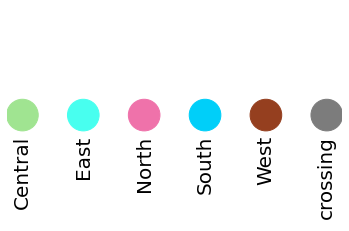

In [418]:
# scatter plot where each dot is a row of the crosswalk and the color is the color column
plt.scatter(np.arange(len(crosswalk)), np.zeros(len(crosswalk)), c=crosswalk['color'], s=np.arange(10, 1000, 1000/len(crosswalk)))
plt.axis('off')

# add region names just below the dots
for i, row in crosswalk.iterrows():
    plt.text(i, -0.01, row['region'], ha='center', va='top', color='k', fontsize=20, rotation=90)

In [37]:
africa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = africa[africa['continent']=="Africa"]

Text(0.5, 0.98, 'Relationship Between Risk and Importance')

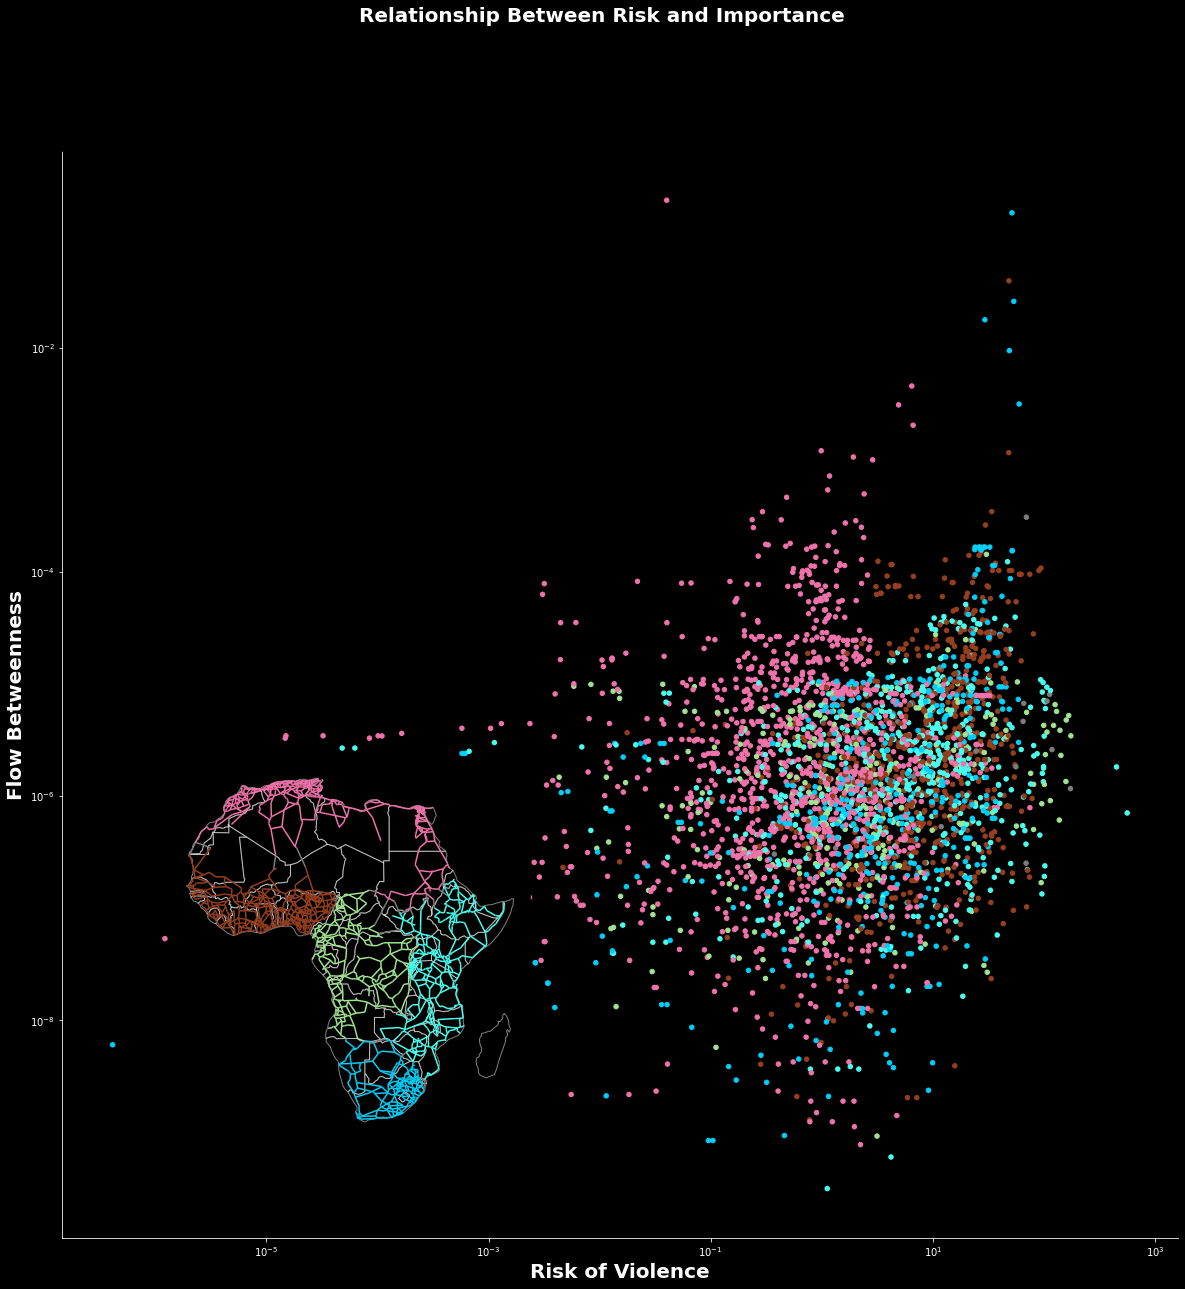

In [38]:
fig, ax = plt.subplots(figsize=(20, 20), facecolor='k')

joined[['risk', 'flow']].plot('risk', 'flow', color=joined['color'], kind='scatter', ax=ax)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_facecolor('k')

ax.spines["bottom"].set_color("w")
ax.spines["left"].set_color("w")

font = {'weight':'bold', 'alpha':1.0, 'size':20}

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

ax.set_xlabel("Risk of Violence", color="w", fontdict=font)
ax.set_ylabel("Flow Betweenness", color="w", fontdict=font)

sub = plt.axes([0.2, 0.05] + [0.25, 0.55], facecolor='#000000')
africa.plot(color='None', edgecolor='w', linewidth=1, alpha=0.5, ax=sub)
joined.plot(color=joined['color'], ax=sub)

# legend = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes['x'], nodes['y'], crs='epsg:4326'))
# legend = legend.merge(crosswalk, left_on='Region', right_on='region', how='left')
# legend.head()

# import math
# legend['markersize'] = np.sqrt(legend['Pop2015'] / 100000)

# legend.plot(color=legend['color'], markersize='markersize', ax=sub)


fig.suptitle('Relationship Between Risk and Importance', color='w', size=20, weight='bold')
# fig.savefig('../viz/africapolis-riskvflow.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')  

Text(0.5, 0.98, 'Relationship Between Risk and Importance')

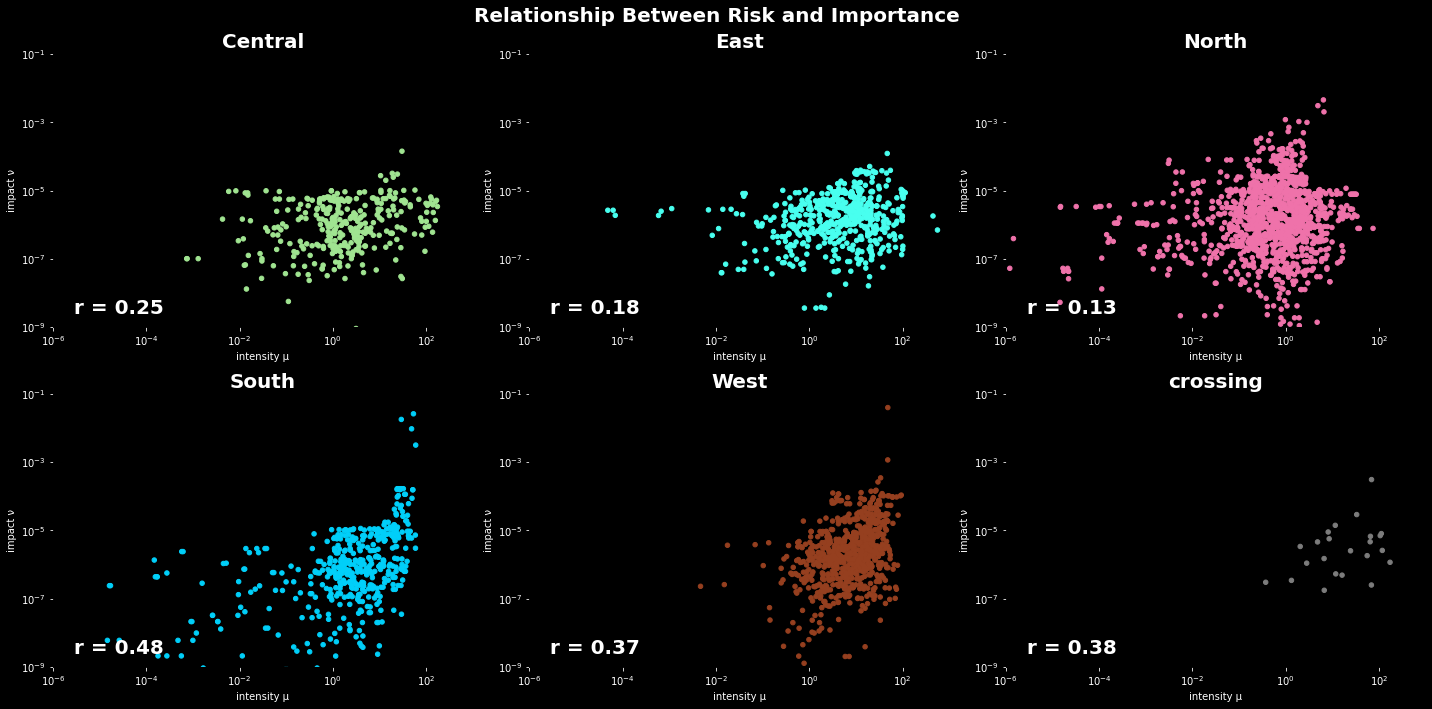

In [39]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10), facecolor='k', tight_layout=True)

# ravel the axes so that we can loop through them
ax = ax.ravel()

# across each axis plot the data per region
for i, r in enumerate(np.unique(region)):
    joined[joined['region']==r][['risk', 'flow']].plot('risk', 'flow', color=joined[joined['region']==r]['color'], kind='scatter', ax=ax[i])

    # clean it up
    ax[i].set_facecolor('k')
    ax[i].set_title(r, color='w', size=20, weight='bold')
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')

    # make sure that the axis ticks are the same across all plots
    ax[i].set_ylim([10**-9, 10**-1])
    ax[i].set_xlim([10**-6, 10**3])

    # sparsify the ticks
    ax[i].set_yticks([10**-9, 10**-7, 10**-5, 10**-3, 10**-1])
    ax[i].set_xticks([10**-6, 10**-4, 10**-2, 10**0, 10**2])

    ax[i].set_xlabel("intensity " + u"\u03BC", color="w")
    ax[i].set_ylabel("impact " + u"\u03BD", color="w")
    ax[i].tick_params(axis='x', colors='w')
    ax[i].tick_params(axis='y', colors='w')

    # add the pearson correlation coefficient to the bottom left of each plot
    from scipy.stats import pearsonr
    temp = joined[joined['flow'] > 0]
    temp = temp[temp['risk'] > 0]
    temp = temp[temp['region']==r]
    corr = pearsonr(np.log(temp[temp['region']==r]['risk']), np.log(temp[temp['region']==r]['flow']))[0].astype(float), pearsonr(np.log(temp[temp['region']==r]['risk']), np.log(temp[temp['region']==r]['flow']))[1].astype(float)
    ax[i].text(0.05, 0.05, 'r = ' + str(round(corr[0], 2)), color='w', transform=ax[i].transAxes, weight='bold', size=20)

fig.suptitle('Relationship Between Risk and Importance', color='w', size=20, weight='bold')
# fig.savefig('../viz/africapolis-riskvflow-regions.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')


In [40]:
# create a dataframe with the bivariate color scheme
bivariate = {
    "class": ["1-1", "2-1", "3-1", "1-2", "2-2", "3-2", "1-3", "2-3", "3-3"],
    "color": ["#e8e8e8", "#ace4e4", "#5ac8c8", "#dfb0d6", "#a5add3", "#5698b9", "#be64ac", "#8c62aa", "#3b4994"]
}

bivariate = pd.DataFrame(bivariate)

In [41]:
# average tween_weighted and index by to
avg_to = joined.groupby('source', as_index=False).mean()[['source', 'risk', 'flow']]
avg_fr = joined.groupby('target', as_index=False).mean()[['target', 'risk', 'flow']]

# merge the two dataframes
avg = avg_to.merge(avg_fr, left_on='source', right_on='target', how='outer', suffixes=['_to', '_from'])

# replace all nan values with 0
avg = avg.fillna(0)

# calculate the mean of the two
avg['risk'] = (avg['risk_to'] + avg['risk_from']) / 2
avg['flow'] = (avg['flow_to'] + avg['flow_from']) / 2
avg['Agglomeration_ID'] = avg['source']

# drop the columns we don't need
avg = avg[['Agglomeration_ID', 'risk', 'flow']]

# join the nodes dataframe to the avg dataframe
avg = avg.merge(nodes, on='Agglomeration_ID')
avg = gpd.GeoDataFrame(avg, geometry=gpd.points_from_xy(avg['x'], avg['y'], crs='epsg:4326'))
avg = avg.to_crs('epsg:3857')

avg.head()

Agglomeration_ID       risk          flow   agglosName          x  \
0               1.0   0.706287  8.956461e-04   10 Ramadan  31.741000   
1               6.0   7.087186  1.305750e-07       Aadado  46.626867   
2               9.0  11.785183  3.153606e-05          Aba   7.357000   
3              10.0   0.000000  3.072530e-07          Aba  30.216358   
4              11.0   0.000000  9.393630e-07  Aba al-Waqf  30.814657   

           y  Pop2015 ISO3   Region       Between  degree  \
0  30.288000   158515  EGY    North  3.365216e+07      10   
1   6.138732    60300  SOM     East  1.476806e+04       2   
2   5.224000  1687158  NGA     West  1.812137e+07       5   
3   3.865970    73000  COD  Central  2.820871e+04       2   
4  28.584467    47881  EGY    North  5.330121e+05       1   

                          geometry  
0  POINT (3533391.957 3540623.536)  
1   POINT (5190479.136 684671.647)  
2    POINT (818977.494 582340.419)  
3   POINT (3363669.531 430684.701)  
4  POINT (3430271.982 3322863.544)

Text(-0.1, 0.5, 'intensity→')

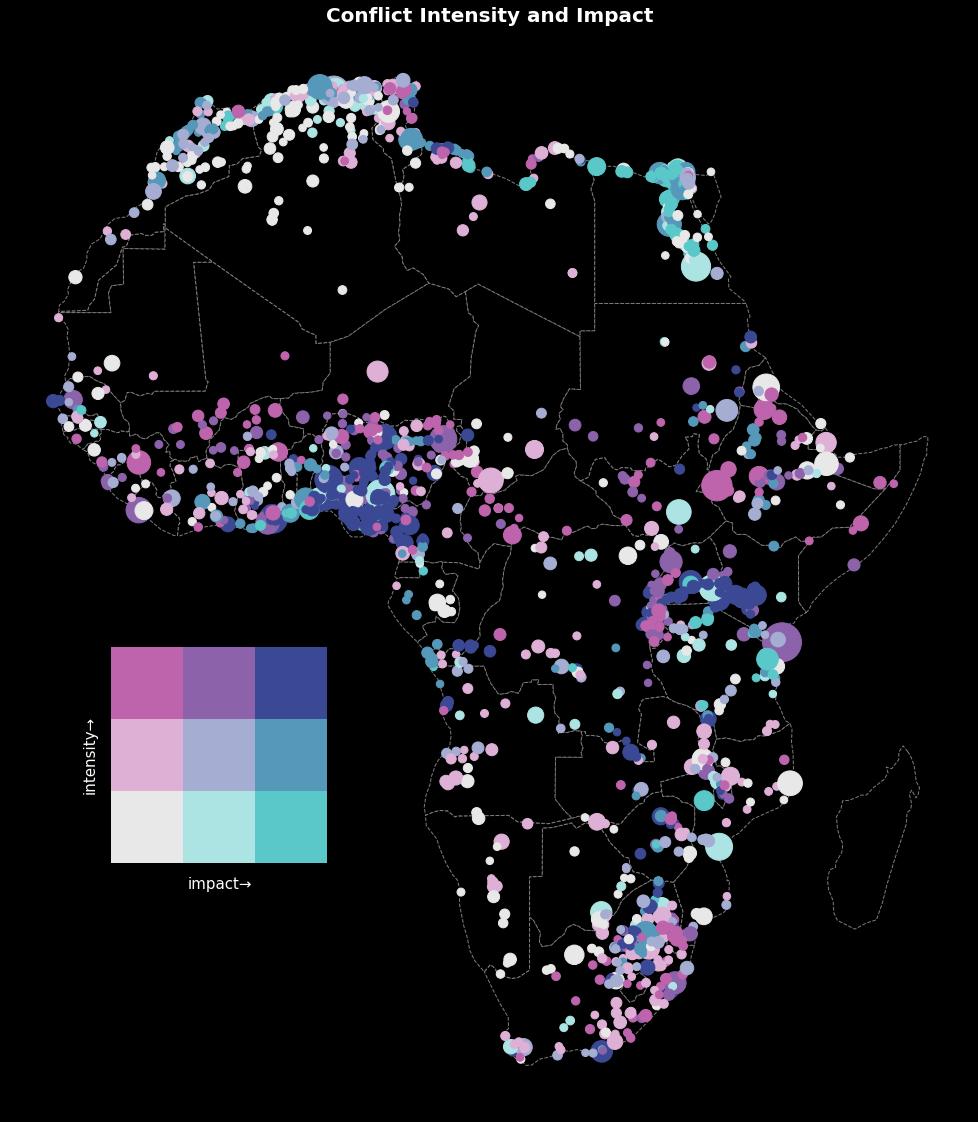

In [42]:
# create a dataframe with the bivariate color scheme
bivariate = {
    "class": ["1-1", "2-1", "3-1", "1-2", "2-2", "3-2", "1-3", "2-3", "3-3"],
    "color": ["#e8e8e8", "#ace4e4", "#5ac8c8", "#dfb0d6", "#a5add3", "#5698b9", "#be64ac", "#8c62aa", "#3b4994"]
}

bivariate = pd.DataFrame(bivariate)

# convert tween_weighted into 3  quantiles 
avg['flow_qtile'] = pd.qcut(avg['flow'].rank(method='first'), 3, labels=["1", "2", "3"])
# replace nan with "1"
avg['flow_qtile'] = avg['flow_qtile'].fillna("1")

# convert index into 3 quantiles
avg['risk_qtile'] = pd.qcut(avg['risk'].rank(method='first'), 3, labels=["1", "2", "3"])
# replace nan with "1"
avg['risk_qtile'] = avg['risk_qtile'].fillna("1")

# join the two quantiles together
avg['class'] = avg['risk_qtile'].astype(str) + "-" + avg['flow_qtile'].astype(str)

# merge the bivariate color scheme with the data
avg = avg.merge(bivariate, on='class')

# create a matplotlib categorical color map with the bi-variate color scheme
from matplotlib.colors import ListedColormap
bmap = ListedColormap(bivariate['color'].values)

# create a geodataframe from the joined dataframe
gdf = gpd.GeoDataFrame(avg)

# make fig and ax objects
fig, ax = plt.subplots(1, 1, figsize=(20, 20), facecolor='k')

# plot africa with no fill and dashed lines as a base layer
africa.to_crs(avg.crs).plot(color='k', edgecolor='#7c7c7c', linestyle='--', ax=ax)

# plot it with the "class" column and use the categorical color map
# edges_gdf.plot(color='w', ax=ax)
gdf.sort_values('Pop2015', ascending=False).plot(column='class', cmap=bmap, ax=ax, markersize=np.sqrt(gdf['Pop2015'] / 10))

# clean it up
ax.set_facecolor('k')
ax.set_title('Conflict Intensity and Impact', color='w', size=20, weight='bold')
ax.set_axis_off()

# make a subplot in the bottom left corner
sub = fig.add_axes([0.25, 0.3, 0.15, 0.15])

sub.imshow(np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]]), cmap=bmap)

# turn it 90 degrees
sub.set_xticks([])
sub.set_yticks([])
sub.set_xticklabels([])
sub.set_yticklabels([])
sub.set_frame_on(False)
sub.invert_yaxis()
sub.set_aspect('equal')

# add axis titles that say "Conflict Intensity" and "Impact"
sub.text(0.5, -0.1, 'impact' + u"\u2192", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=15, color='w')
sub.text(-0.1, 0.5, 'intensity' + u"\u2192", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=15, rotation=90, color='w')

# save this plot as a high resolution png
# plt.savefig('../viz/africapolis-riskvflow-map.png', dpi=300, bbox_inches='tight', pad_inches=0)


Text(-0.1, 0.5, 'intensity→')

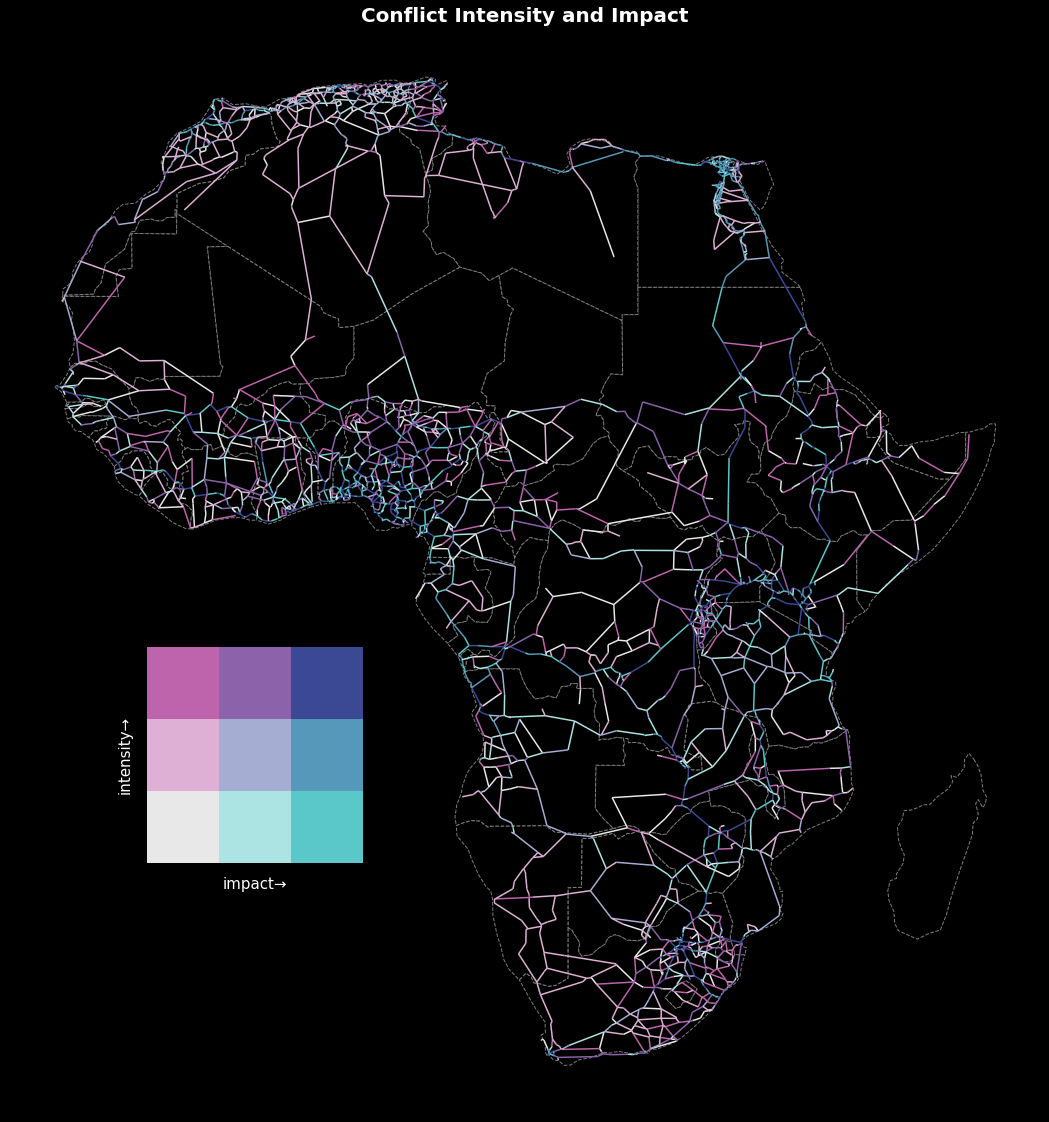

In [43]:
# create a dataframe with the bivariate color scheme
bivariate = {
    "class": ["1-1", "2-1", "3-1", "1-2", "2-2", "3-2", "1-3", "2-3", "3-3"],
    "color": ["#e8e8e8", "#ace4e4", "#5ac8c8", "#dfb0d6", "#a5add3", "#5698b9", "#be64ac", "#8c62aa", "#3b4994"]
}

bivariate = pd.DataFrame(bivariate)

# copy data
ready = joined.copy()

# convert tween_weighted into 3  quantiles 
ready['flow_qtile'] = pd.qcut(ready['flow'].rank(method='first'), 3, labels=["1", "2", "3"])

# convert index into 3 quantiles
ready['risk_qtile'] = pd.qcut(ready['risk'].rank(method='first'), 3, labels=["1", "2", "3"])

# # replace na values with the first quantile
# ready['flow_qtile'] = ready['flow_qtile'].fillna("1")
# ready['risk_qtile'] = ready['risk_qtile'].fillna("1")

# join the two quantiles together
ready['class'] = ready['risk_qtile'].astype(str) + "-" + ready['flow_qtile'].astype(str)

# merge the bivariate color scheme with the data
ready = ready.merge(bivariate, on='class')

# create a matplotlib categorical color map with the bi-variate color scheme
from matplotlib.colors import ListedColormap
bmap = ListedColormap(bivariate['color'].values)

# make fig and ax objects
fig, ax = plt.subplots(1, 1, figsize=(20, 20), facecolor='k')

# plot africa with no fill and dashed lines as a base layer
africa.to_crs(ready.crs).plot(color='k', edgecolor='#7c7c7c', linestyle='--', ax=ax)

# plot it with the "class" column and use the categorical color map
# joined.plot(color='w', ax=ax)
ready.plot(column='class', cmap=bmap, ax=ax)

# clean it up
ax.set_facecolor('k')
ax.set_title('Conflict Intensity and Impact', color='w', size=20, weight='bold')
ax.set_axis_off()

# make a subplot in the bottom left corner
sub = fig.add_axes([0.25, 0.3, 0.15, 0.15])

sub.imshow(np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]]), cmap=bmap)

# turn it 90 degrees
sub.set_xticks([])
sub.set_yticks([])
sub.set_xticklabels([])
sub.set_yticklabels([])
sub.set_frame_on(False)
sub.invert_yaxis()
sub.set_aspect('equal')

# add axis titles that say "Conflict Intensity" and "Impact"
sub.text(0.5, -0.1, 'impact' + u"\u2192", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=15, color='w')
sub.text(-0.1, 0.5, 'intensity' + u"\u2192", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=15, rotation=90, color='w')

# save this plot as a high resolution png
# plt.savefig('../viz/africapolis-riskvflow-edges.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [49]:
def bivariate_choropleth(data, basemap, voi_1, voi_2, scheme, background='k', **kwargs):
    # set parameters if kwargs are not passed
    tit = kwargs.get('title', "")
    lb1 = kwargs.get('label1', "")
    lb2 = kwargs.get('label2', "")
    fnm = kwargs.get('fnm', "")
    pts = kwargs.get('pts', 1)
    lwd = kwargs.get('lwd', 1)
    # if lwd is a str, create the vector for widths
    if type(lwd) == "str":
        lwd = data[lwd] * 5

    # create a dataframe with the bivariate color scheme
    bivariate = pd.DataFrame(scheme)

    if background == 'k':
        foreground = 'w'
    else:
        foreground = 'k'

    # copy data
    ready = data.copy()

    # convert tween_weighted into 3  quantiles 
    ready['voi1_qtile'] = pd.qcut(ready[voi_1].rank(method='first'), 3, labels=["1", "2", "3"])

    # convert index into 3 quantiles
    ready['voi2_qtile'] = pd.qcut(ready[voi_2].rank(method='first'), 3, labels=["1", "2", "3"])

    # # replace na values with the first quantile
    # ready['flow_qtile'] = ready['flow_qtile'].fillna("1")
    # ready['risk_qtile'] = ready['risk_qtile'].fillna("1")

    # join the two quantiles together
    ready['class'] = ready['voi2_qtile'].astype(str) + "-" + ready['voi1_qtile'].astype(str)

    # merge the bivariate color scheme with the data
    ready = ready.merge(bivariate, on='class')

    # create a matplotlib categorical color map with the bi-variate color scheme
    from matplotlib.colors import ListedColormap
    bmap = ListedColormap(bivariate['color'].values)

    # make fig and ax objects
    fig, ax = plt.subplots(1, 1, figsize=(20, 20), facecolor=background)

    # plot africa with no fill and dashed lines as a base layer
    basemap.to_crs(ready.crs).plot(color=background, edgecolor='#7c7c7c', linestyle='--', ax=ax)

    # plot it with the "class" column and use the categorical color map
    # joined.plot(color='w', ax=ax)
    if ready.geom_type[0] == 'LineString':
        ready.plot(column='class', linewidth=lwd, cmap=bmap, ax=ax)
    else:
        ready.sort_values(pts, ascending=False).plot(column='class', cmap=bmap, ax=ax, markersize=np.sqrt(ready[pts] / 10))

    # clean it up
    ax.set_facecolor(background)
    ax.set_title(tit, color=foreground, size=20, weight='bold')
    ax.set_axis_off()

    # make a subplot in the bottom left corner
    sub = fig.add_axes([0.25, 0.3, 0.15, 0.15])

    sub.imshow(np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]]), cmap=bmap)

    # turn it 90 degrees
    sub.set_xticks([])
    sub.set_yticks([])
    sub.set_xticklabels([])
    sub.set_yticklabels([])
    sub.set_frame_on(False)
    sub.invert_yaxis()
    sub.set_aspect('equal')

    # add axis titles that say "Conflict Intensity" and "Impact"
    sub.text(0.5, -0.1, lb1 + u"\u2192", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=15, color=foreground)
    sub.text(-0.1, 0.5, lb2 + u"\u2192", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=15, rotation=90, color=foreground)

    # create subplot with 3 circles off different sizes
    

    # # save this plot as a high resolution png
    if fnm != "":
        plt.savefig(fnm, dpi=300, bbox_inches='tight', pad_inches=0)

In [438]:
nodes.sort_values('Pop2015', ascending=False).head(10)

Agglomeration_ID     agglosName       x       y   Pop2015 ISO3   Region  \
0              2320          Cairo  31.324  30.130  22995802  EGY    North   
1              5199          Lagos   3.316   6.668  11847635  NGA     West   
2              7098        Onitsha   6.928   5.815   8530514  NGA     West   
3              4220   Johannesburg  28.016 -26.050   8314220  ZAF    South   
4              4858       Kinshasa  15.293  -4.408   7270000  COD  Central   
5              5331         Luanda  13.385  -8.924   6979211  AGO  Central   
6               597     Alexandria  29.797  31.125   6585102  EGY    North   
7              6509        Nairobi  36.813  -1.181   5877118  KEN     East   
8              2622  Dar es Salaam  39.177  -6.807   5325879  TZA     East   
9              4740        Khartum  32.538  15.522   5264746  SDN    North   

        Between  degree                          geometry            X_  \
0  6.979617e+07       6   POINT (3486971.730 3520271.100)  3.486972e+06   
1  3.127663e+07       4     POINT (369135.431 743959.626)  3.691354e+05   
2  2.110388e+07       6     POINT (771221.432 648436.990)  7.712214e+05   
3  3.568974e+07       5  POINT (3118726.854 -3005274.977)  3.118727e+06   
4  1.119784e+06       4   POINT (1702408.973 -491181.093)  1.702409e+06   
5  2.296774e+06       3   POINT (1490011.384 -997456.220)  1.490011e+06   
6  2.974547e+07       9   POINT (3316986.867 3648993.435)  3.316987e+06   
7  9.670022e+06       4   POINT (4098004.415 -131477.629)  4.098004e+06   
8  3.489327e+06       4   POINT (4361163.691 -759540.641)  4.361164e+06   
9  5.337278e+06       7   POINT (3622113.591 1749433.153)  3.622114e+06   

             Y_  
0  3.520271e+06  
1  7.439596e+05  
2  6.484370e+05  
3 -3.005275e+06  
4 -4.911811e+05  
5 -9.974562e+05  
6  3.648993e+06  
7 -1.314776e+05  
8 -7.595406e+05  
9  1.749433e+06

In [433]:
# reference populations
reference_pops = [500]
# get 3 values
sizes = np.arange(1000, 9000, 9000/3)
# square each one and multiply by 10
sizes = sizes**2 * 10
sizes

array([1.0e+07, 1.6e+08, 4.9e+08])

/Users/asr/opt/anaconda3/envs/locomizer/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


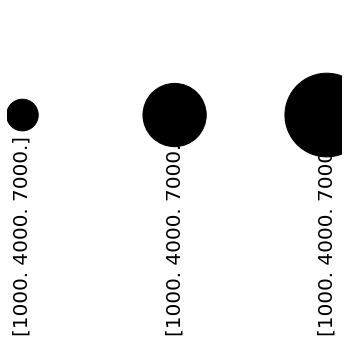

In [436]:
# scatter plot where each dot is a row of the crosswalk and the color is the color column
plt.scatter(np.arange(len(sizes)), np.zeros(len(sizes)), c='k', s=np.arange(1000, 9000, 9000/3))
plt.axis('off')

# add region names just below the dots
for i in np.arange(len(sizes)):
    plt.text(i, -0.01, np.arange(1000, 9000, 9000/3), ha='center', va='top', color='k', fontsize=20, rotation=90)

In [132]:
# colours = {
#     "class": ["1-1", "2-1", "3-1", "1-2", "2-2", "3-2", "1-3", "2-3", "3-3"],
#     "color": ["#e8e8e8", "#ace4e4", "#5ac8c8", "#dfb0d6", "#a5add3", "#5698b9", "#be64ac", "#8c62aa", "#3b4994"]
# }

# params = {'title': 'Conflict Intensity and Impact', 'label1': 'impact', 'label2': 'intensity', 'lwd': 2}
# bivariate_choropleth(joined, africa, "flow", "risk", scheme=colours, background='w', **params)

In [133]:
# params = {'title': '', 'label1': 'impact', 'label2': 'intensity', 'pts': 'Pop2015', 'fnm': '../viz/africapolis-riskvflow-white.png'}
# bivariate_choropleth(avg, africa, "flow", "risk", scheme=colours, background='w', **params)

In [134]:
# fig, ax = plt.subplots(2, 3, figsize=(20, 10), facecolor='w', tight_layout=True)

# # ravel the axes so that we can loop through them
# ax = ax.ravel()

# # across each axis plot the data per region
# for i, r in enumerate(np.unique(region)):
#     joined[joined['region']==r][['risk', 'flow']].plot('risk', 'flow', color=joined[joined['region']==r]['color'], kind='scatter', ax=ax[i])

#     # clean it up
#     ax[i].set_facecolor('w')
#     ax[i].set_title(r, color='k', size=20, weight='bold')
#     ax[i].set_yscale('log')
#     ax[i].set_xscale('log')

#     # make sure that the axis ticks are the same across all plots
#     ax[i].set_ylim([10**-9, 10**-1])
#     ax[i].set_xlim([10**-6, 10**3])

#     # sparsify the ticks
#     ax[i].set_yticks([10**-9, 10**-7, 10**-5, 10**-3, 10**-1])
#     ax[i].set_xticks([10**-6, 10**-4, 10**-2, 10**0, 10**2])

#     ax[i].set_xlabel("intensity " + u"\u03BC", color="k")
#     ax[i].set_ylabel("impact " + u"\u03BD", color="k")
#     ax[i].tick_params(axis='x', colors='k')
#     ax[i].tick_params(axis='y', colors='k')
    
#     # remove splines
#     ax[i].spines['top'].set_visible(False)
#     ax[i].spines['right'].set_visible(False)

#     # add the pearson correlation coefficient to the bottom left of each plot
#     from scipy.stats import pearsonr
#     temp = joined[joined['flow'] > 0]
#     temp = temp[temp['risk'] > 0]
#     temp = temp[temp['region']==r]
#     corr = pearsonr(np.log(temp[temp['region']==r]['risk']), np.log(temp[temp['region']==r]['flow']))[0].astype(float), pearsonr(np.log(temp[temp['region']==r]['risk']), np.log(temp[temp['region']==r]['flow']))[1].astype(float)
#     ax[i].text(0.05, 0.05, 'r = ' + str(round(corr[0], 2)), color='k', transform=ax[i].transAxes, weight='bold', size=20)

# # fig.savefig('../viz/africapolis-riskvflow-regions-white.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')

In [135]:
# create geodataframe with x,y in nodes data
# nodes.drop(columns=['geometry'], inplace=True)
nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes.x, nodes.y), crs="EPSG:4326")
nodes = nodes.to_crs("EPSG:3857")

# add columns for the x and y coordinates
nodes['X_'] = nodes.geometry.x
nodes['Y_'] = nodes.geometry.y

nodes.head()

agglosName       x       y   Pop2015 ISO3   Region  \
Agglomeration_ID                                                         
2320                     Cairo  31.324  30.130  22995802  EGY    North   
5199                     Lagos   3.316   6.668  11847635  NGA     West   
7098                   Onitsha   6.928   5.815   8530514  NGA     West   
4220              Johannesburg  28.016 -26.050   8314220  ZAF    South   
4858                  Kinshasa  15.293  -4.408   7270000  COD  Central   

                       Between  degree                          geometry  \
Agglomeration_ID                                                           
2320              6.979617e+07       6   POINT (3486971.730 3520271.100)   
5199              3.127663e+07       4     POINT (369135.431 743959.626)   
7098              2.110388e+07       6     POINT (771221.432 648436.990)   
4220              3.568974e+07       5  POINT (3118726.854 -3005274.977)   
4858              1.119784e+06       4   POINT (1702408.973 -491181.093)   

                            X_            Y_  
Agglomeration_ID                              
2320              3.486972e+06  3.520271e+06  
5199              3.691354e+05  7.439596e+05  
7098              7.712214e+05  6.484370e+05  
4220              3.118727e+06 -3.005275e+06  
4858              1.702409e+06 -4.911811e+05

In [136]:
from scipy.spatial.distance import pdist, squareform
distances = squareform(pdist(nodes[['X_', 'Y_']]))
distances = [np.where(i < 10**5)[0] for i in distances]

In [137]:
nodes.reset_index(inplace=True)

In [138]:
def get_cuts(edges, nodes, distances=distances):
    # randomly sample an edge according to the risk
    test = edges.sample(n=1, weights='risk')
    seed = (test.source.values[0], test.target.values[0])
    test = nodes[(nodes['Agglomeration_ID']==test.source.values[0])|(nodes['Agglomeration_ID']==test.target.values[0])]

    # get the indices of the source and target nodes
    set_1 = set(distances[test.index.values[0]])
    set_2 = set(distances[test.index.values[1]])

    # get the union of the two sets
    set_u = set_1.union(set_2)

    # get all edges with u or v in the set
    adjacent = edges[(edges.source.isin(set_u))|(edges.target.isin(set_u))]
    adjacent = adjacent[adjacent['risk'] > 0]

    if adjacent.shape[0] > 0:
        n = np.random.randint(0, adjacent.shape[0])
        # choose a random number between 1 and the number of rows in adjacent
        adjacent = adjacent.sample(n=n, weights='risk', replace=False)

        # convert source, target columns to source, target pairs
        adjacent = adjacent[['source', 'target']].values

        # convert to list of tuples
        adjacent = [tuple(x) for x in adjacent if tuple(x) != seed]
        adjacent.append(seed)
    else:
        adjacent = [(seed)]

    return adjacent

In [175]:
x = []
y = []
z = []

# convert joined to graph from edgelist
Gi = nx.from_pandas_edgelist(joined, source='source', target='target', edge_attr='risk')

for i in np.arange(0, 1000):
    G_ = Gi.copy()
    cuts = get_cuts(joined, nodes)
    _ = [G_.remove_edge(j[0], j[1]) for j in cuts]

    # get the regions for each isolate
    region_i = [Ni.loc[j, 'Region'] for j in nx.isolates(G_)]
    # get the modal region, unless there are no isolates, in which case return nan
    if len(region_i) == 0:
        region_i = np.nan
    else:
        region_i = max(set(region_i), key=region_i.count)

    # count the number of isolates in the graph
    x.append(len(list(nx.isolates(G_))))
    y.append(sum([Ni.loc[j, 'Pop2015'] for j in nx.isolates(G_)]))
    z.append(region_i)


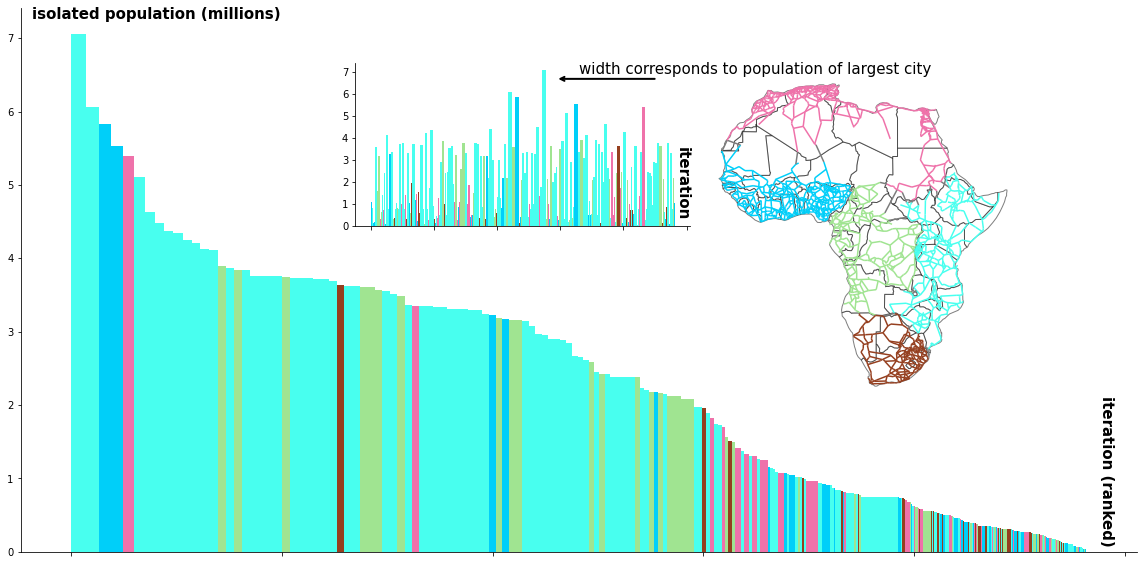

In [423]:

reg2col = {
    'region': ['Central', 'East', 'North', 'South', 'West', 'crossing', 'nan'],
    'color': ['#a0e491', '#48ffef', '#ef72aa', '#953f1f', '#00cff9', '#7c7c7c', '#ffffff']
}

reg2col = dict(zip(reg2col['region'], reg2col['color']))

# sort x by the number of isolates
x = np.array(x)
y = np.array(y)
z = np.array(z)
x_sorted = x[np.argsort(y)]
y_sorted = y[np.argsort(y)]
z_sorted = z[np.argsort(y)]

# reverse these arrays
x_sorted = x_sorted[::-1]
y_sorted = y_sorted[::-1]
z_sorted = z_sorted[::-1]

xticks=[]
for n, c in enumerate(np.arange(0, 1000)):
    xticks.append(sum(y_sorted[:n]) + y_sorted[n]/2)
    

# make a barchart of lengths
fig, ax = plt.subplots(figsize=(20, 10), facecolor='w')
ax.bar(xticks, y_sorted, color=[reg2col.get(i) for i in z_sorted], width=y_sorted)

# # make x axis tickets every 100
# ax.set_xticks(np.arange(0, 1100, 100))

# add a title
# ax.set_title('Number of Isolates in the Network', size=20, weight='bold')
ax.text(0.01, 0.98, 'isolated population (millions)', transform=ax.transAxes, size=15, weight='bold')
# add text in the lower right for the iteration number
ax.text(0.98, 0.01, 'iteration (ranked)', transform=ax.transAxes, size=15, weight='bold', rotation=270, ha='right', va='bottom')

# remove the right and top splines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# import ticker
import matplotlib.ticker as ticker

# divide axis labels by 1000
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/10**6)))

# remove x labels
ax.set_xticklabels([])

# inset map
map = plt.axes([0.6, 0.3] + [0.22, 0.53], facecolor='#ffffff')
africa[africa['iso_a3']!= 'MDG'].plot(color='w', edgecolor='k', linewidth=1, alpha=0.5, ax=map)
joined.plot(color=joined['color'], ax=map)
map.set_axis_off()

# inset
axins = ax.inset_axes([0.3, 0.6, 0.3, 0.3])
xticks=[]
for n, c in enumerate(np.arange(0, 1000)):
    xticks.append(sum(y[:n]) + y[n]/2)

axins.bar(xticks, y, color=[reg2col.get(i) for i in z], width=y)

# remove the right and top splines
axins.spines['right'].set_visible(False)
axins.spines['top'].set_visible(False)
axins.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/10**6)))
axins.set_xticklabels([])

# add a curved arrow
axins.annotate('', xy=(0.6, 0.9), xycoords='axes fraction', xytext=(0.9, 0.9), textcoords='axes fraction', arrowprops=dict(arrowstyle='->', color='k', lw=2))
axins.text(0.50, 0.88, 'width corresponds to population of largest city', transform=ax.transAxes, size=15)

# labels
axins.text(0.6, 0.61, 'iteration', transform=ax.transAxes, size=15, weight='bold', rotation=270, ha='right', va='bottom')

# save the figure
fig.savefig('../viz/africapolis-isolates-switched.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')

In [141]:
Ei = joined.copy()
Ei['risk'] = Ei['risk'] / Ei['risk'].max()

Ni = nodes.copy()
Ni = nodes.set_index('Agglomeration_ID')

# convert joined to graph from edgelist
Gi = nx.from_pandas_edgelist(Ei, source='source', target='target', edge_attr=['risk', 'flow'])

# a function that cuts an edge based on the probability of the risk
def cut_edge(G):
    damage = 0 
    # convert to edgelist
    edges = nx.to_pandas_edgelist(G)
    # sample an edge
    edge = edges.sample(n=1, weights='risk', replace=False)
    # get the source and target
    source = edge.source.values[0]
    target = edge.target.values[0]
    # remove the edge
    damage += G.get_edge_data(source, target)['flow']
    G.remove_edge(source, target)
    # get all edges with either source or target
    edges = edges[(edges.source==source)|(edges.target==target)|(edges.source==target)|(edges.target==source)]
    # remove the original edge
    edges = edges[~((edges.source==source)&(edges.target==target))]
    # for each edge, flip a coin with the odds of the risk
    for i, row in edges.iterrows():
        if np.random.random() < row['risk']:
            damage += G.get_edge_data(row['source'], row['target'])['flow']
            G.remove_edge(row['source'], row['target'])
    return (G, damage)

# initialize a dictionary to store the isolates
isolates_dict = dict()
stranded_dict = dict()
lengths_dict = dict()
component_dict = dict()
damage_dict = dict()

# run through 1000 iterations
for i in np.arange(0, 100):
    if i % 10 == 0:
        print(i)
    # copy the graph
    G_ = Gi.copy()
    # create a list to store the number of isolates
    isolates = []
    stranded = []
    lengths = []
    component = []
    damages = []
    totals = sum([d['risk'] for u, v, d in G_.edges(data=True)])
    # # run through 1000 cuts
    # for j in np.arange(0, 500):
    #     G_ = cut_edge(G_)
    #     # count the number of isolates in the graph
    #     isolates.append(len(list(nx.isolates(G_))))
    #     # compute the size of the largest connected component
    #     lengths.append(len(max(nx.connected_components(G_), key=len)))
    damage = 0
    # cut edges until there are no more edges
    while totals > 0:
        G_, d = cut_edge(G_)
        damage += d
        # count the number of isolates in the graph
        isolates.append(len(list(nx.isolates(G_))))
        # get the population of the isolates
        stranded.append(sum([Ni.loc[i, 'Pop2015'] for i in nx.isolates(G_)]))
        # compute the size of the largest connected component
        lengths.append(len(max(nx.connected_components(G_), key=len)))
        # get the total population of the largerst connected component
        component.append(sum([Ni.loc[i, 'Pop2015']for i in max(nx.connected_components(G_), key=len)]))
        # add the damage
        damages.append(damage)
        # recompute the total risk
        totals = sum([d['risk'] for u, v, d in G_.edges(data=True)])

    # store the isolates and lengths in a dictionary with the iteration number
    isolates_dict[i] = isolates
    stranded_dict[i] = stranded
    lengths_dict[i] = lengths
    component_dict[i] = component
    damage_dict[i] = damages


0
10
20
30
40
50
60
70
80
90


In [143]:
# copy the lengths dictionary
lengths_dict_ = lengths_dict.copy()

# get the maximum length of all lists in the dict
max_length = max([len(i) for i in lengths_dict_.values()])
max_length

# pad each entry with 0 to the length of the longest list
for i in lengths_dict_.keys():
    lengths_dict_[i] = np.pad(lengths_dict_[i], (0, max_length-len(lengths_dict_[i])), 'constant')

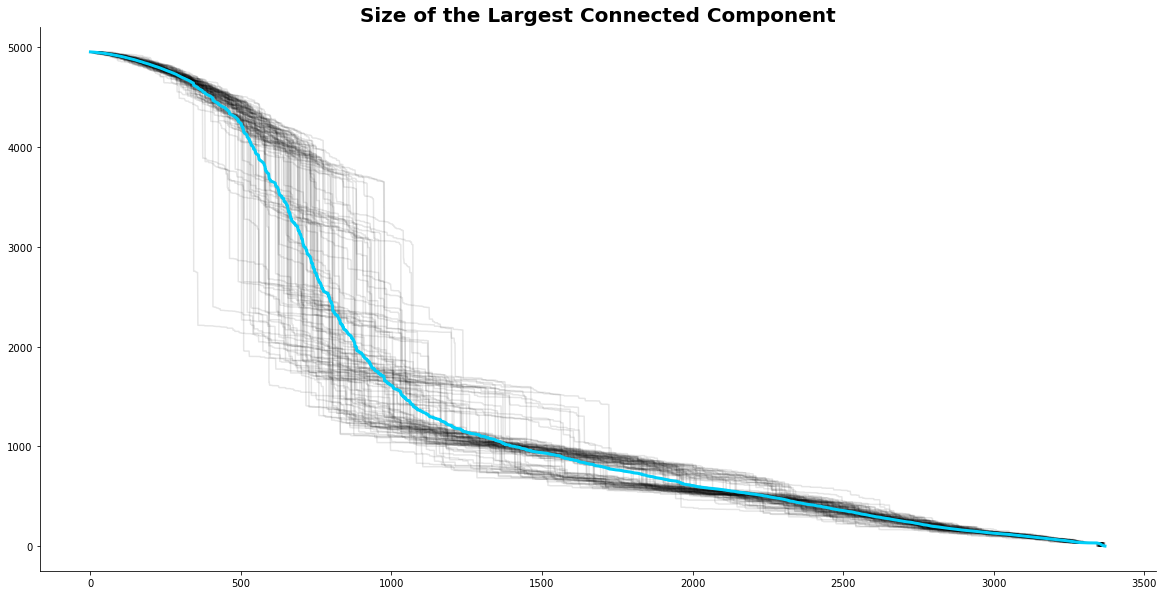

In [144]:
# plot the gcc size at a line plot
fig, ax = plt.subplots(figsize=(20, 10))
for i in lengths_dict_.keys():
    ax.plot(lengths_dict_[i], color='k', alpha=0.1)

ax.plot(np.mean(list(lengths_dict_.values()), axis=0), color=crosswalk.color.iloc[3], linewidth=3)
ax.set_title('Size of the Largest Connected Component', size=20, weight='bold')

# remove the right and top splines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# save the figure
# fig.savefig('../viz/africapolis-gcc-markov-total.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')

In [145]:
# copy the lengths dictionary
isolates_dict_ = isolates_dict.copy()

# get the maximum length of all lists in the dict
max_isolate = max([len(i) for i in isolates_dict_.values()])
max_isolate

# pad each entry with 0 to the length of the longest list
for i in isolates_dict_.keys():
    isolates_dict_[i] = np.pad(isolates_dict_[i], (0, max_isolate-len(isolates_dict_[i])), 'constant')

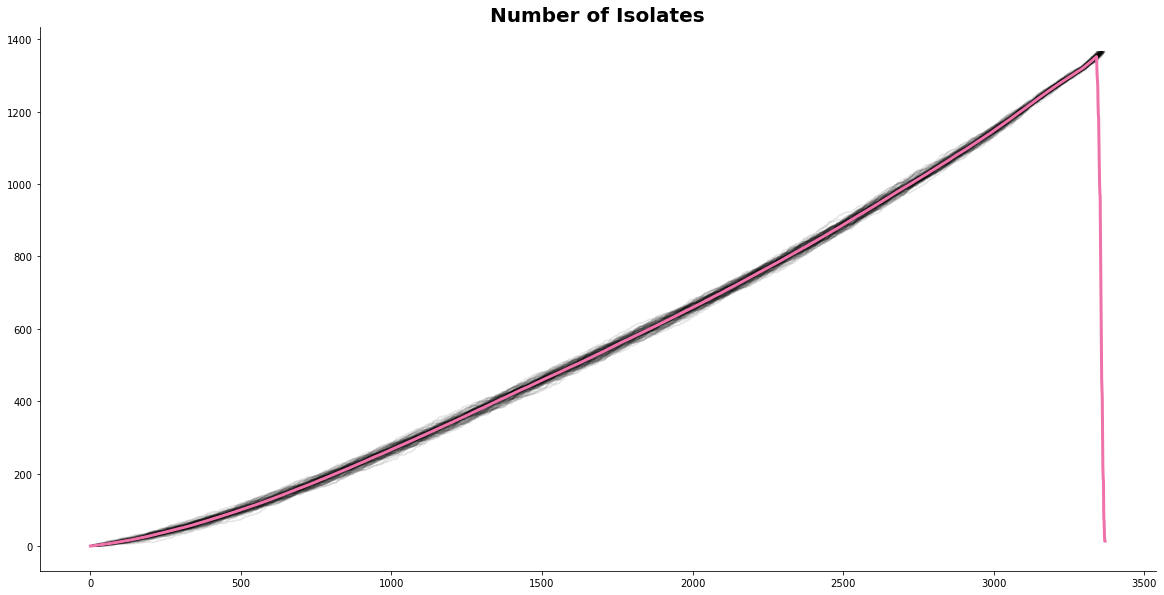

In [146]:
# plot the gcc size at a line plot
fig, ax = plt.subplots(figsize=(20, 10))
for i in isolates_dict.keys():
    ax.plot(isolates_dict[i], color='k', alpha=0.1)
    
# ax.plot(np.mean(list(lengths_dict.values()), axis=0), color='k', linewidth=3)
ax.plot(np.mean(list(isolates_dict_.values()), axis=0), color=crosswalk.color.iloc[2], linewidth=3)
ax.set_title('Number of Isolates', size=20, weight='bold')

# remove the right and top splines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# # save the figure
# fig.savefig('../viz/africapolis-isolates-markov-total.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')

In [147]:
# copy the lengths dictionary
damage_dict_ = damage_dict.copy()

# multiply all values by 2
for i in damage_dict_.keys():
    damage_dict_[i] = [j*2 for j in damage_dict_[i]]

# get the maximum length of all lists in the dict
max_damage = max([len(i) for i in damage_dict_.values()])
max_damage

# pad each entry with 0 to the length of the longest list
for i in isolates_dict_.keys():
    damage_dict_[i] = np.pad(damage_dict_[i], (0, max_damage-len(damage_dict_[i])), 'edge')

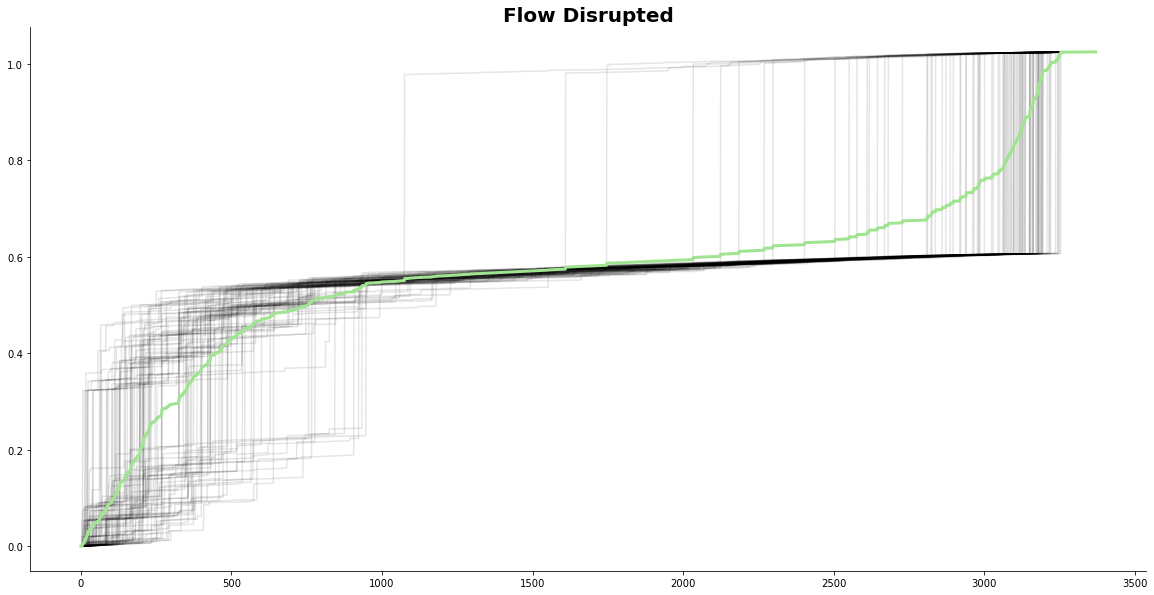

In [148]:
# plot the gcc size at a line plot
fig, ax = plt.subplots(figsize=(20, 10))
for i in damage_dict_.keys():
    ax.plot(damage_dict_[i], color='k', alpha=0.1)

ax.plot(np.mean(list(damage_dict_.values()), axis=0), color=crosswalk.color.iloc[0], linewidth=3)
ax.set_title('Flow Disrupted', size=20, weight='bold')

# remove the right and top splines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# save the figure
fig.savefig('../viz/africapolis-flow-disruption.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')

Text(0.5, 1.0, 'Number of Isolates')

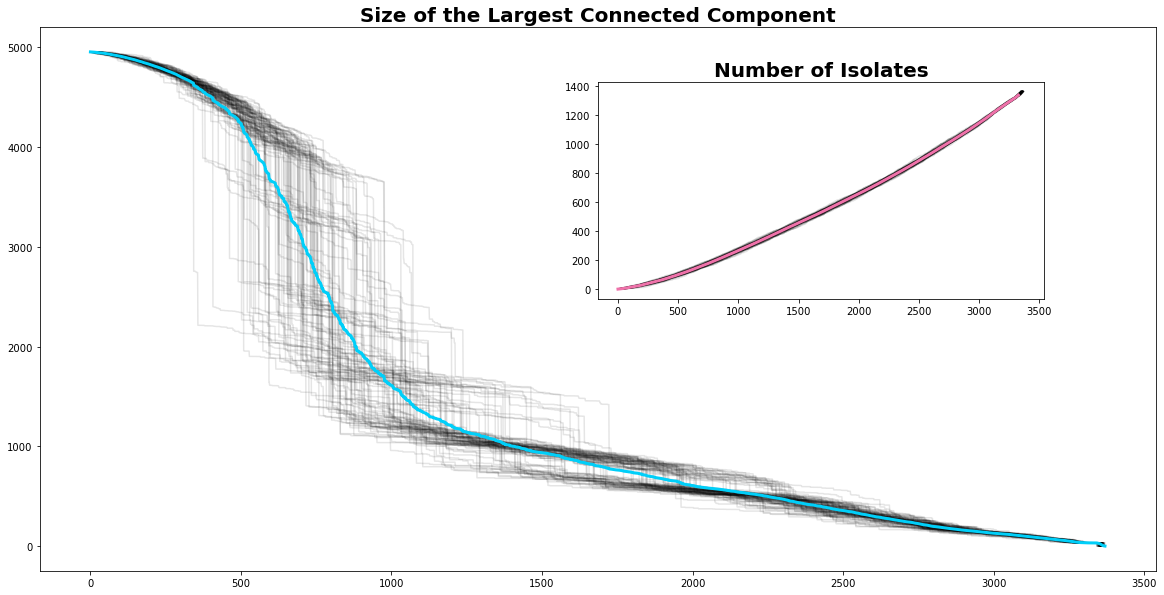

In [149]:
# plot the gcc size at a line plot
fig, ax = plt.subplots(figsize=(20, 10))
for i in lengths_dict_.keys():
    ax.plot(lengths_dict_[i], color='k', alpha=0.1)

ax.plot(np.mean(list(lengths_dict_.values()), axis=0), color=crosswalk.color.iloc[3], linewidth=3)
ax.set_title('Size of the Largest Connected Component', size=20, weight='bold')

# remove the right and top splines
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# build an inset plot with the isolates
axins = ax.inset_axes([0.5, 0.5, 0.4, 0.4])
for i in isolates_dict.keys():
    axins.plot(isolates_dict[i], color='k', alpha=0.1)

axins.plot(np.mean(list(isolates_dict_.values()), axis=0)[:-45], color=crosswalk.color.iloc[2], linewidth=3)
axins.set_title('Number of Isolates', size=20, weight='bold')

# save the figure
# fig.savefig('../viz/africapolis-markov-total.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')

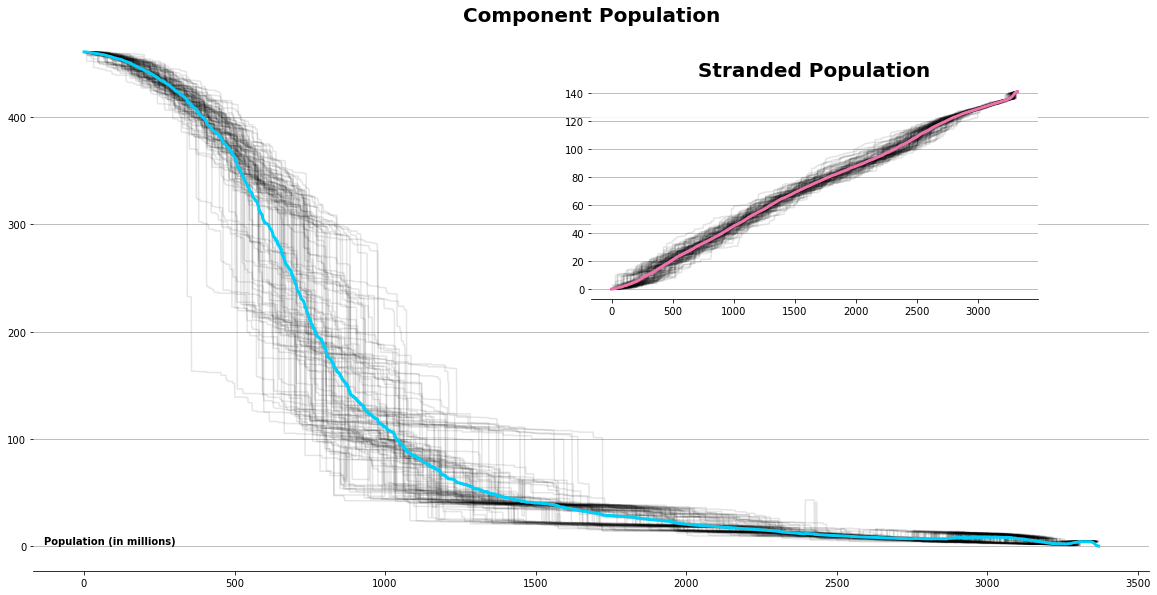

In [150]:
# copy the lengths dictionary
component_dict_ = component_dict.copy()

# get the maximum component population of all lists in the dict
max_component = max([len(i) for i in component_dict_.values()])

# pad each entry with 0 to the length of the longest list
for i in component_dict_.keys():
    component_dict_[i] = np.pad(component_dict_[i], (0, max_component-len(component_dict_[i])), 'constant')

# copy the lengths dictionary
stranded_dict_ = stranded_dict.copy()

# get the maximum stranded people of all lists in the dict
max_stranded = max([len(i) for i in stranded_dict_.values()])

# pad each entry with 0 to the length of the longest list
for i in stranded_dict_.keys():
    stranded_dict_[i] = np.pad(stranded_dict_[i], (0, max_stranded-len(stranded_dict_[i])), 'edge')

# plot the damage over time
fig, ax = plt.subplots(figsize=(20, 10))
for i in component_dict.keys():
    ax.plot(component_dict[i], color='k', alpha=0.1)

ax.plot(np.mean(list(component_dict_.values()), axis=0), color=crosswalk.color.iloc[3], linewidth=3)
ax.set_title('Component Population', size=20, weight='bold')

# build an inset plot with the isolates
axins = ax.inset_axes([0.5, 0.5, 0.4, 0.4])
for i in stranded_dict_.keys():
    axins.plot(stranded_dict_[i][:-45], color='k', alpha=0.1)

axins.plot(np.mean(list(stranded_dict_.values()), axis=0)[:-45], color=crosswalk.color.iloc[2], linewidth=3)
axins.set_title('Stranded Population', size=20, weight='bold')

# remove scientific notation, use commas instead
ax.ticklabel_format(style='plain')
axins.ticklabel_format(style='plain')

# import ticker
import matplotlib.ticker as ticker

# divide axis labels by 1000
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/10**6)))
axins.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/10**6)))

# add text to show that the tick labels are in millions
ax.text(0.01, 0.05, 'Population (in millions)', transform=ax.transAxes, size=10, weight='bold')

# show horizontal gridlines
ax.grid(axis='y')

# remove vertical splines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# add horizontal gridlines to subplot
axins.grid(axis='y')

# remove vertical splines
axins.spines['right'].set_visible(False)
axins.spines['top'].set_visible(False)
axins.spines['left'].set_visible(False)

# set the limits of the inset plot to be 45 less on the x-axis
# axins.set_xlim(0, 1455)

# make the whole subplot transparent
axins.patch.set_alpha(0.9)

# save the figure
# fig.savefig('../viz/africapolis-population-markov-total.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')


In [151]:
Ei = joined.copy()
Ei['risk'] = Ei['risk'] / Ei['risk'].max()

Ni = nodes.copy()
Ni = nodes.set_index('Agglomeration_ID')

# janky function to deal with edges that got reverse in this process
def join_edges(el1, el2):
    Ei = el1.copy()
    Ec = el2.copy()
    Ei['edge_id'] = Ei['source'].astype(str) + '_' + Ei['target'].astype(str)
    Ec['edge_id'] = Ec['from'].astype(str) + '_' + Ec['to'].astype(str)
    E1 = Ec[Ec.edge_id.isin(Ei.edge_id)]
    E2 = Ec[~Ec.edge_id.isin(Ei.edge_id)]
    E2['edge_id'] = E2['to'].astype(str) + '_' + E2['from'].astype(str)
    Ec = pd.concat([E1, E2], ignore_index=True)
    Ei = Ei.merge(Ec[['edge_id', 'l']], on=['edge_id'], how='left')
    return Ei.drop(columns=['edge_id'], axis=1)

# add lengths
Ei = join_edges(Ei, edges) 

# add edge lengths as an attribute
Gi = nx.from_pandas_edgelist(Ei, source='source', target='target', edge_attr=['risk', 'flow', 'l'])

# create an empty dictionary to store the detours
detours = {}

# loop through all edges of the graph
for i, j in Gi.edges():
    # save a detour of there is no shortest path after cutting the edge
    d = 0
    # get the length of the edge
    l = Gi[i][j]['l']
    # get the flow on the edge
    f = Gi[i][j]['flow']
    # get the risk on the edge
    r = Gi[i][j]['risk']
    # remove the edge
    Gi.remove_edge(i, j)
    # check if there is a shortest path after removing the edge
    if nx.has_path(Gi, i, j):
        # if there is a shortest path, get the length of the shortest path
        p = nx.shortest_path_length(Gi, i, j, weight='l')
    else:
        # if there is no shortest path, set the length of the shortest path to infinity
        p = np.inf
    # the detour is the length of the shortest path minus the length of the edge
    d = p - l
    # save all the values in a dictionary
    detours[(i, j)] = {'length': l, 'flow': f, 'risk': r, 'detour': d}

/var/folders/xj/s_z3mksd2s9_pz9rv68sbjxc0000gn/T/ipykernel_71954/2877407375.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  E2['edge_id'] = E2['to'].astype(str) + '_' + E2['from'].astype(str)


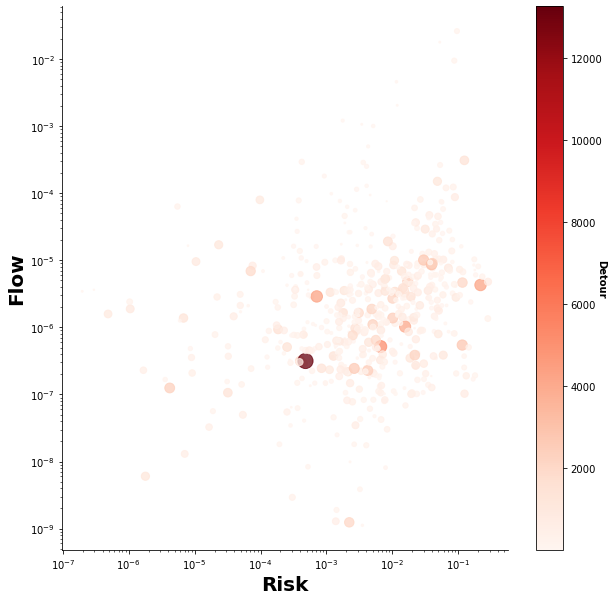

In [154]:
# import cm, colors
import matplotlib.cm as cm
import matplotlib.colors as colors

# convert the dictionary to a dataframe
testing = pd.DataFrame.from_dict(detours, orient='index')
# set the index names as to, from
testing.index.names = ['to', 'from']
# reset the index
testing = testing.reset_index()
# change inf to the maximum value
# testing.detour = testing.detour.replace(np.inf, testing[testing.detour!=np.inf].detour.max())

# scatterplot with the risk on the x-axis, the flow on the y-axis, and the detour as the size/colour of the points
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(testing.risk, testing.flow, s=np.sqrt(testing.detour) * 2, c=testing.detour, cmap='Reds', alpha=0.75)

# log scale the x-axis
ax.set_xscale('log')
# log scale the y-axis
ax.set_yscale('log')

# remove right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set the x-axis label
ax.set_xlabel('Risk', size=20, weight='bold')

# set the y-axis label
ax.set_ylabel('Flow', size=20, weight='bold')

# add a colourbar to the inset legend
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=testing[testing.detour!=np.inf].detour.min(), vmax=testing[testing.detour!=np.inf].detour.max()), cmap='Reds'), orientation='vertical')

# set the label of the colourbar
cbar.set_label('Detour', size=10, weight='bold', rotation=270)



Text(0.5, 0.98, 'Relationship Between Risk and Importance')

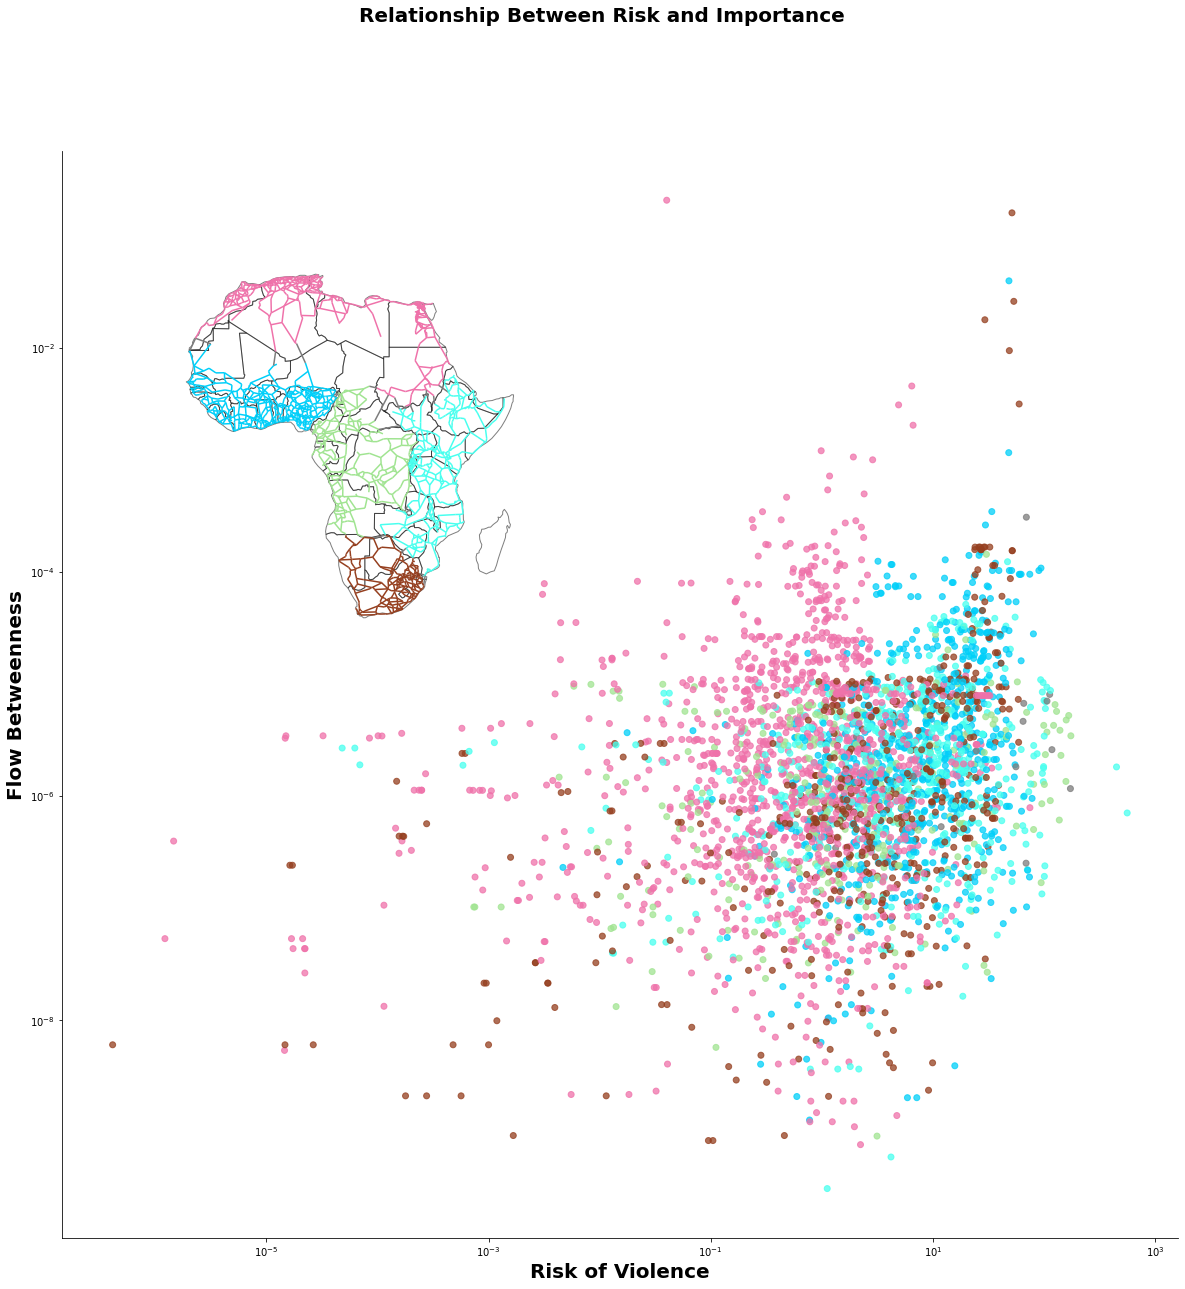

In [420]:
fig, ax = plt.subplots(figsize=(20, 20), facecolor='w')

# joined[['risk', 'flow']].plot('risk', 'flow', color=joined['color'], kind='scatter', ax=ax)
ax.scatter(joined.risk, joined.flow, c=joined['color'], alpha=0.75)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_facecolor('w')

ax.spines["bottom"].set_color("k")
ax.spines["left"].set_color("k")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

font = {'weight':'bold', 'alpha':1.0, 'size':20}

ax.tick_params(axis='x', colors='k')
ax.tick_params(axis='y', colors='k')

ax.set_xlabel("Risk of Violence", color="k", fontdict=font)
ax.set_ylabel("Flow Betweenness", color="k", fontdict=font)

sub = plt.axes([0.2, 0.4] + [0.25, 0.55], facecolor='#ffffff')
africa.plot(color='None', edgecolor='k', linewidth=1, alpha=0.5, ax=sub)
joined.plot(color=joined['color'], ax=sub)
sub.set_axis_off()

# legend = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes['x'], nodes['y'], crs='epsg:4326'))
# legend = legend.merge(crosswalk, left_on='Region', right_on='region', how='left')
# legend.head()

# import math
# legend['markersize'] = np.sqrt(legend['Pop2015'] / 100000)

# legend.plot(color=legend['color'], markersize='markersize', ax=sub)

fig.suptitle('Relationship Between Risk and Importance', color='k', size=20, weight='bold')
# fig.savefig('../viz/africapolis-riskvflow-white.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')  

In [405]:
def plot_histogram(data, axis):
    # plot the histogram on y axis on the left side
    axis.hist(np.log10(data[data.detour!=np.inf].detour + 1), bins=50, orientation='vertical')

    # reverse cc.cm.CET_I3 so that the colours are in the right order
    # reversed = cc.cm.CET_I3.reversed()

    # fill the bars with the colourmap
    for i, p in enumerate(axis.patches):
        p.set_facecolor(cc.cm.CET_I3(i/len(axis.patches)))

    import matplotlib.ticker as ticker
    axis.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: r'$10^{{{:d}}}$'.format(int(x))))

    # reverse the axis
    # axis.invert_yaxis()

    # move the y ticks to the right side of the plot
    axis.yaxis.tick_right()
    # ticks 10 - 70 every 10
    axis.set_yticks(np.arange(10, 70, 10))

    # remove top, bottom and right splines
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['left'].set_visible(False)

    #  remove ticks and labels on left
    # axis.tick_params(axis='y', which='both', left=False, labelleft=False)

    return axis

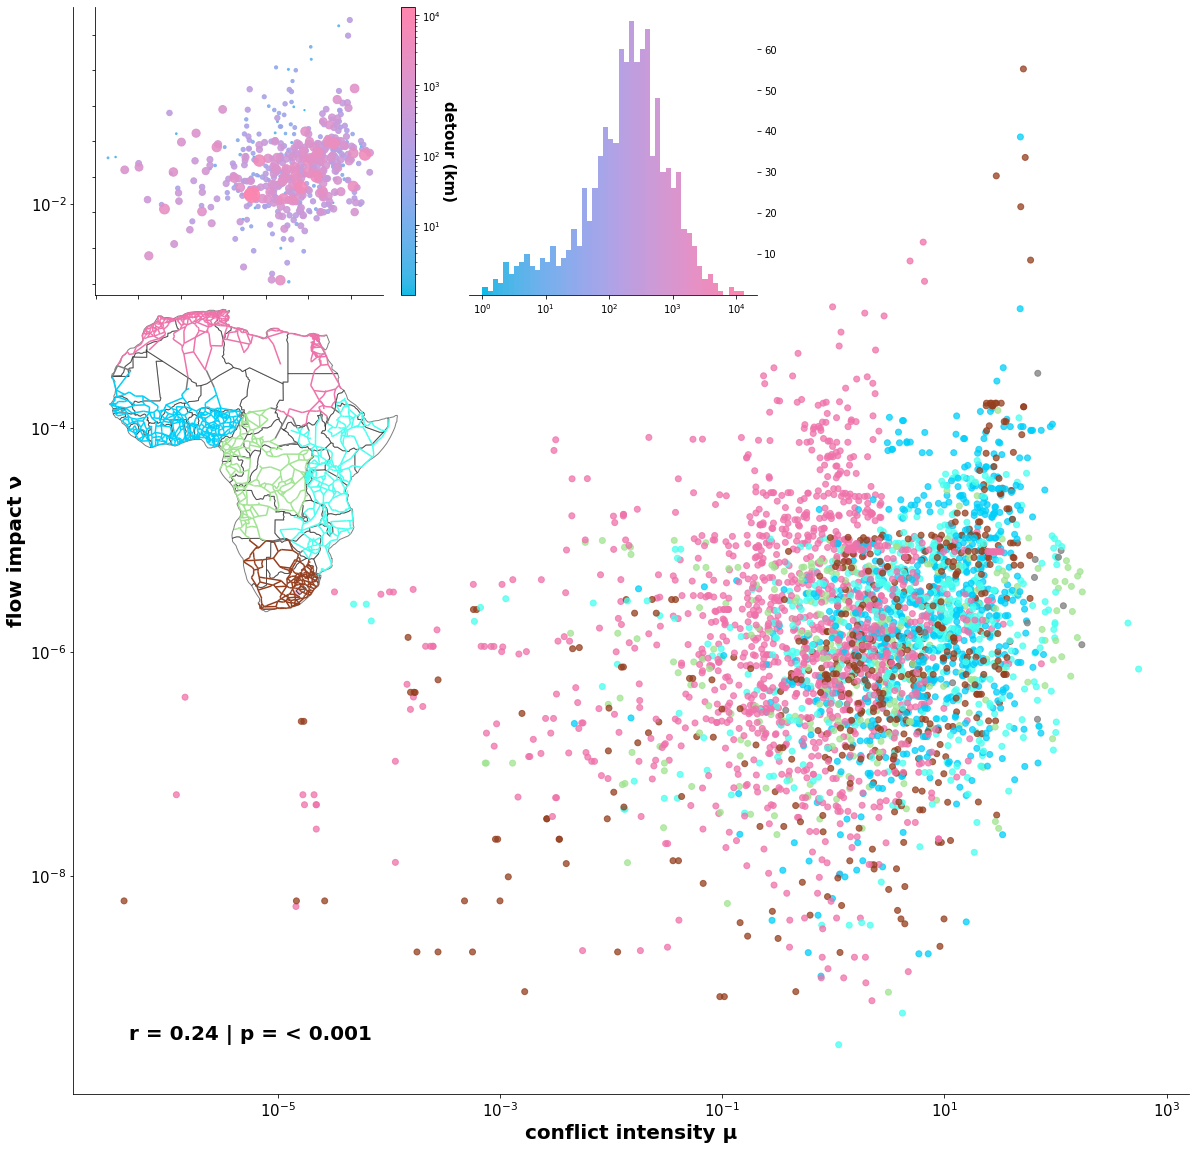

In [421]:
fig, ax = plt.subplots(figsize=(20, 20), facecolor='w')

# joined[['risk', 'flow']].plot('risk', 'flow', color=joined['color'], kind='scatter', ax=ax)
ax.scatter(joined.risk, joined.flow, c=joined['color'], alpha=0.75)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_facecolor('w')

ax.spines["bottom"].set_color("k")
ax.spines["left"].set_color("k")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

font = {'weight':'bold', 'alpha':1.0, 'size':20}

ax.tick_params(axis='x', colors='k')
ax.tick_params(axis='y', colors='k')

# increase the size of the ticks
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_xlabel("conflict intensity" + " " + u"\u03BC", color="k", fontdict=font)
ax.set_ylabel("flow impact" + " " + u"\u03BD", color="k", fontdict=font)

testing = testing.sort_values('detour', ascending=True)

sub = plt.axes([0.14, 0.68] + [0.25, 0.2], facecolor='#ffffff')
sub.scatter(testing.risk, testing.flow, s=np.sqrt(testing.detour) * 2, c=np.log(testing.detour + 1), cmap=cc.cm.CET_I3, alpha=0.9)

# log scale the x-axis
sub.set_xscale('log')
# log scale the y-axis
sub.set_yscale('log')

# turn off the ticks
sub.tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False)
# turn off the tick labels
sub.tick_params(axis='both', which='major', labelbottom=False, labeltop=False, labelleft=False, labelright=False)

# remove right and top spines
sub.spines['right'].set_visible(False)
sub.spines['top'].set_visible(False)

# # set the x-axis label
# sub.set_xlabel('Risk', size=20, weight='bold')

# # set the y-axis label
# sub.set_ylabel('Flow', size=20, weight='bold')

# add a colourbar to the inset legend
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin=testing[testing.detour!=np.inf].detour.min() + 1, vmax=testing[testing.detour!=np.inf].detour.max()), cmap=cc.cm.CET_I3), orientation='vertical')
# set the label of the colourbar
cbar.set_label('detour (km)', size=15, weight='bold', rotation=270, labelpad=15)

hst = plt.axes([0.4, 0.68]  + [0.2, 0.2], facecolor='#ffffff')
hst = plot_histogram(testing, hst)

# inset map
map = plt.axes([0.14, 0.3] + [0.22, 0.53], facecolor='#ffffff')
africa[africa['iso_a3']!= 'MDG'].plot(color='w', edgecolor='k', linewidth=1, alpha=0.5, ax=map)
joined.plot(color=joined['color'], ax=map)
map.set_axis_off()

from scipy.stats import pearsonr
temp = joined[joined['flow'] > 0]
temp = temp[temp['risk'] > 0]
corr = pearsonr(np.log(temp['risk']), np.log(temp['flow']))[0].astype(float), pearsonr(np.log(temp['risk']), np.log(temp['flow']))
r = corr[1][0]
p = corr[1][1]

# round the p value
if p < 0.001:
    p = "< 0.001"
elif p < 0.01:
    p = "< 0.01"
elif p < 0.05:
    p = "< 0.05"
else:
    p = "> 0.05"

ax.text(0.05, 0.05, 'r = ' + str(round(r, 2)) + " | p = " + p, color='k', transform=ax.transAxes, weight='bold', size=20)

# fig.suptitle('Relationship Between Risk and Importance', color='k', size=20, weight='bold')
fig.savefig('../viz/africapolis-riskvflow-agg-white-switched.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')  

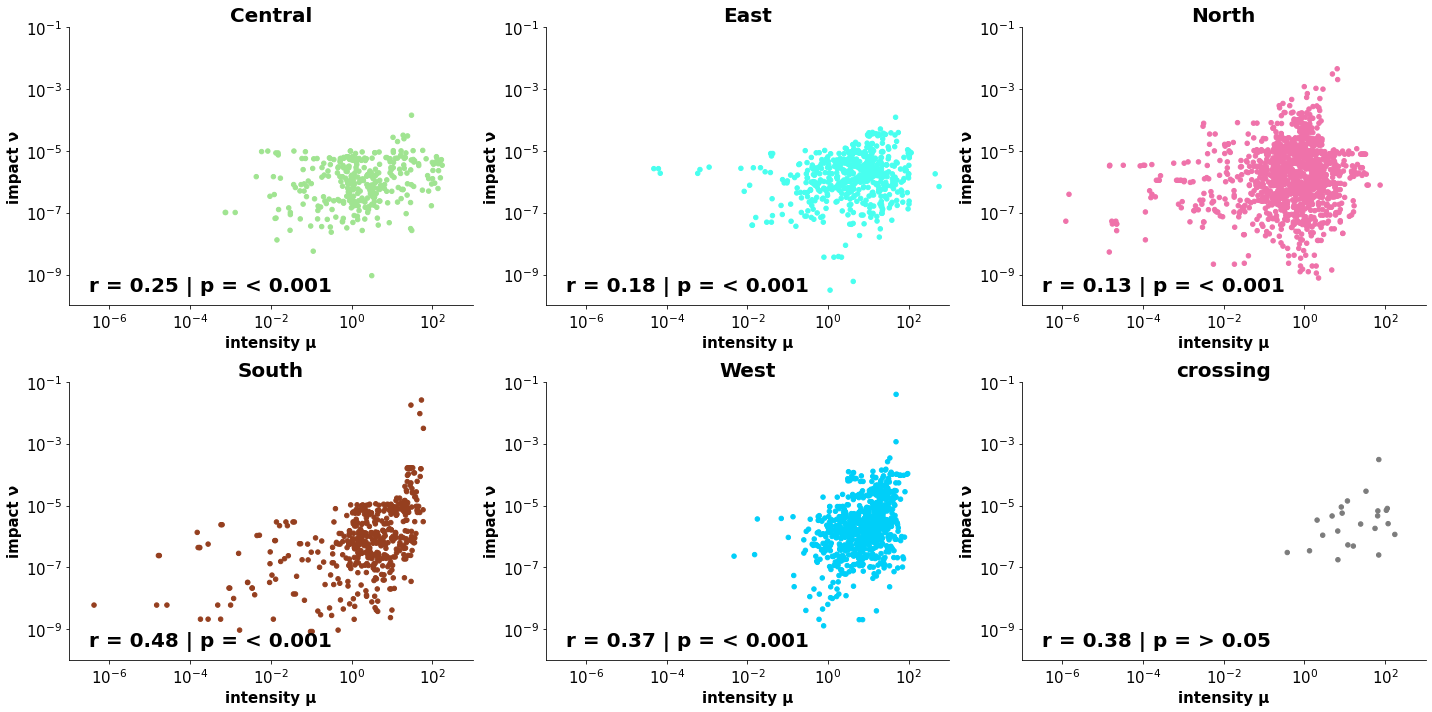

In [422]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10), facecolor='w', tight_layout=True)

# ravel the axes so that we can loop through them
ax = ax.ravel()

# across each axis plot the data per region
for i, r in enumerate(np.unique(region)):
    joined[joined['region']==r][['risk', 'flow']].plot('risk', 'flow', color=joined[joined['region']==r]['color'], kind='scatter', ax=ax[i])

    # clean it up
    ax[i].set_facecolor('w')
    ax[i].set_title(r, color='k', size=20, weight='bold')
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')

    # make sure that the axis ticks are the same across all plots
    ax[i].set_ylim([10**-10, 10**-1])
    ax[i].set_xlim([10**-7, 10**3])

    # sparsify the ticks
    ax[i].set_yticks([10**-9, 10**-7, 10**-5, 10**-3, 10**-1])
    ax[i].set_xticks([10**-6, 10**-4, 10**-2, 10**0, 10**2])

    ax[i].set_xlabel("intensity " + u"\u03BC", color="k", size=15, weight='bold')
    ax[i].set_ylabel("impact " + u"\u03BD", color="k", size=15, weight='bold')
    ax[i].tick_params(axis='x', colors='k')
    ax[i].tick_params(axis='y', colors='k')

    # increase the size of the ticks
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    # remove the minor ticks
    ax[i].tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False)

    # remove splines
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    # add the pearson correlation coefficient to the bottom left of each plot
    from scipy.stats import pearsonr
    temp = joined[joined['flow'] > 0]
    temp = temp[temp['risk'] > 0]
    temp = temp[temp['region']==r]
    corr = pearsonr(np.log(temp[temp['region']==r]['risk']), np.log(temp[temp['region']==r]['flow']))[0].astype(float), pearsonr(np.log(temp[temp['region']==r]['risk']), np.log(temp[temp['region']==r]['flow']))
    r = corr[1][0]
    p = corr[1][1]

    # round the p value
    if p < 0.001:
        p = "< 0.001"
    elif p < 0.01:
        p = "< 0.01"
    elif p < 0.05:
        p = "< 0.05"
    else:
        p = "> 0.05"

    ax[i].text(0.05, 0.05, 'r = ' + str(round(r, 2)) + " | p = " + p, color='k', transform=ax[i].transAxes, weight='bold', size=20)

fig.savefig('../viz/africapolis-riskvflow-regions-white-horizontal-switched.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')

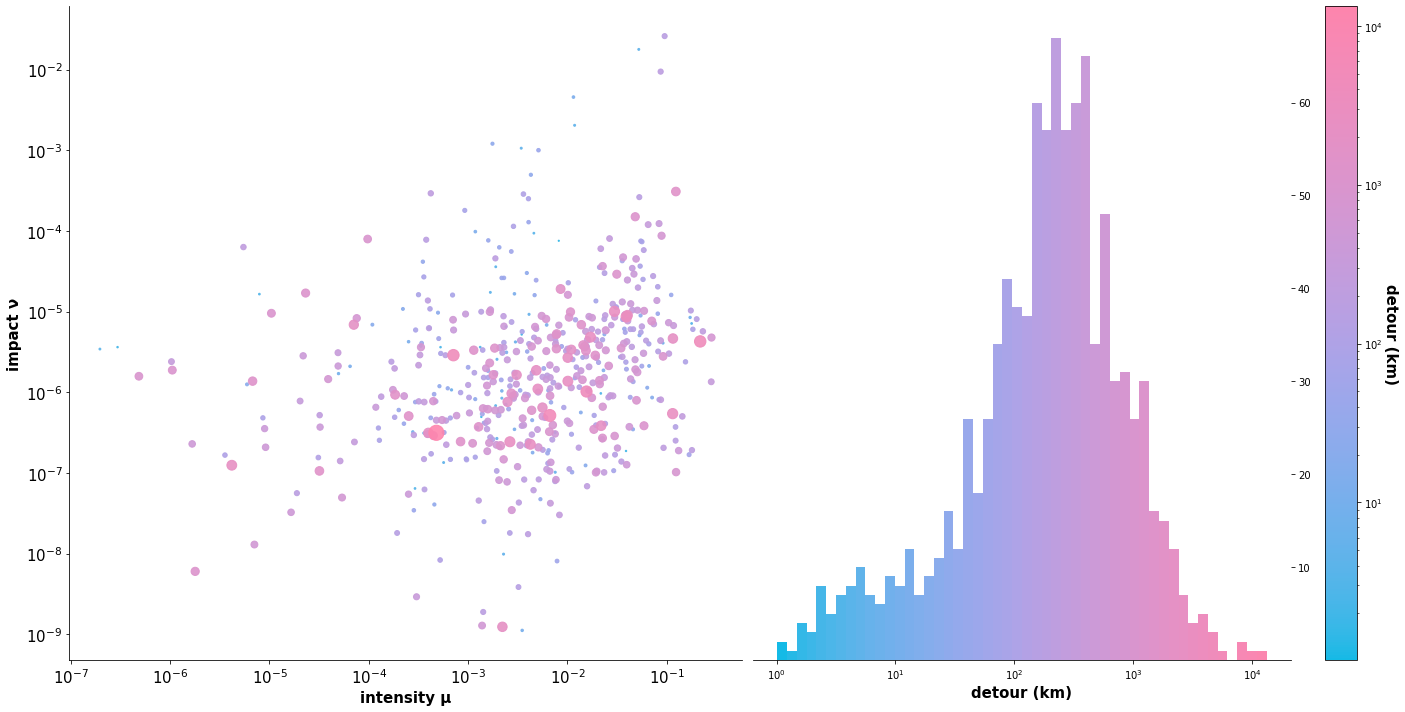

In [452]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), facecolor='w', tight_layout=True)

# ravel the axes so that we can loop through them
axs = axs.ravel()

axs[0].scatter(testing.risk, testing.flow, s=np.sqrt(testing.detour) * 2, c=np.log(testing.detour + 1), cmap=cc.cm.CET_I3, alpha=0.9)

# log scale the x-axis
axs[0].set_xscale('log')
# log scale the y-axis
axs[0].set_yscale('log')

axs[0].tick_params(axis='x', colors='k')
axs[0].tick_params(axis='y', colors='k')

# increase the size of the ticks
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[0].tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False)

# remove right and top spines
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

axs[0].set_xlabel("intensity " + u"\u03BC", color="k", size=15, weight='bold')
axs[0].set_ylabel("impact " + u"\u03BD", color="k", size=15, weight='bold')

# add a colourbar to the inset legend
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin=testing[testing.detour!=np.inf].detour.min() + 1, vmax=testing[testing.detour!=np.inf].detour.max()), cmap=cc.cm.CET_I3), orientation='vertical')
# set the label of the colourbar
cbar.set_label('detour (km)', size=15, weight='bold', rotation=270, labelpad=15)

hst = plot_histogram(testing, axs[1])
hst.set_xlabel("detour (km)", color="k", size=15, weight='bold')

fig.savefig('../viz/africapolis-detour-white.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')

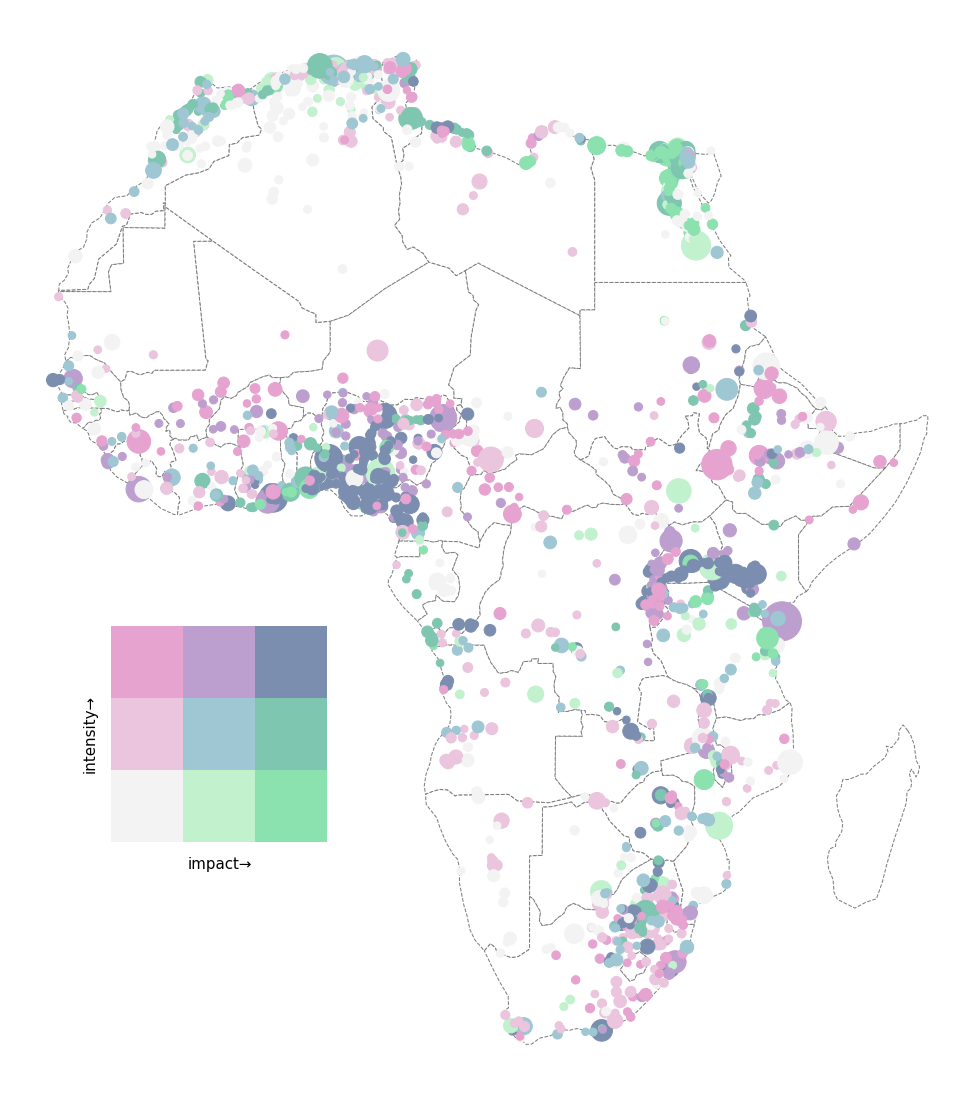

In [45]:
colours = {
    "class": ["1-1", "2-1", "3-1", "1-2", "2-2", "3-2", "1-3", "2-3", "3-3"], 
    "color": ["#f3f3f3", "#c2f1ce", "#8be2af", "#eac5dd", "#9ec6d3", "#7fc6b1", "#e6a3d0", "#bc9fce", "#7b8eaf"]
}

params = {'title': '', 'label1': 'impact', 'label2': 'intensity', 'pts': 'Pop2015', 'fnm': '../viz/africapolis-riskvflow-white.png'}
bivariate_choropleth(avg, africa, "flow", "risk", scheme=colours, background='w', **params)

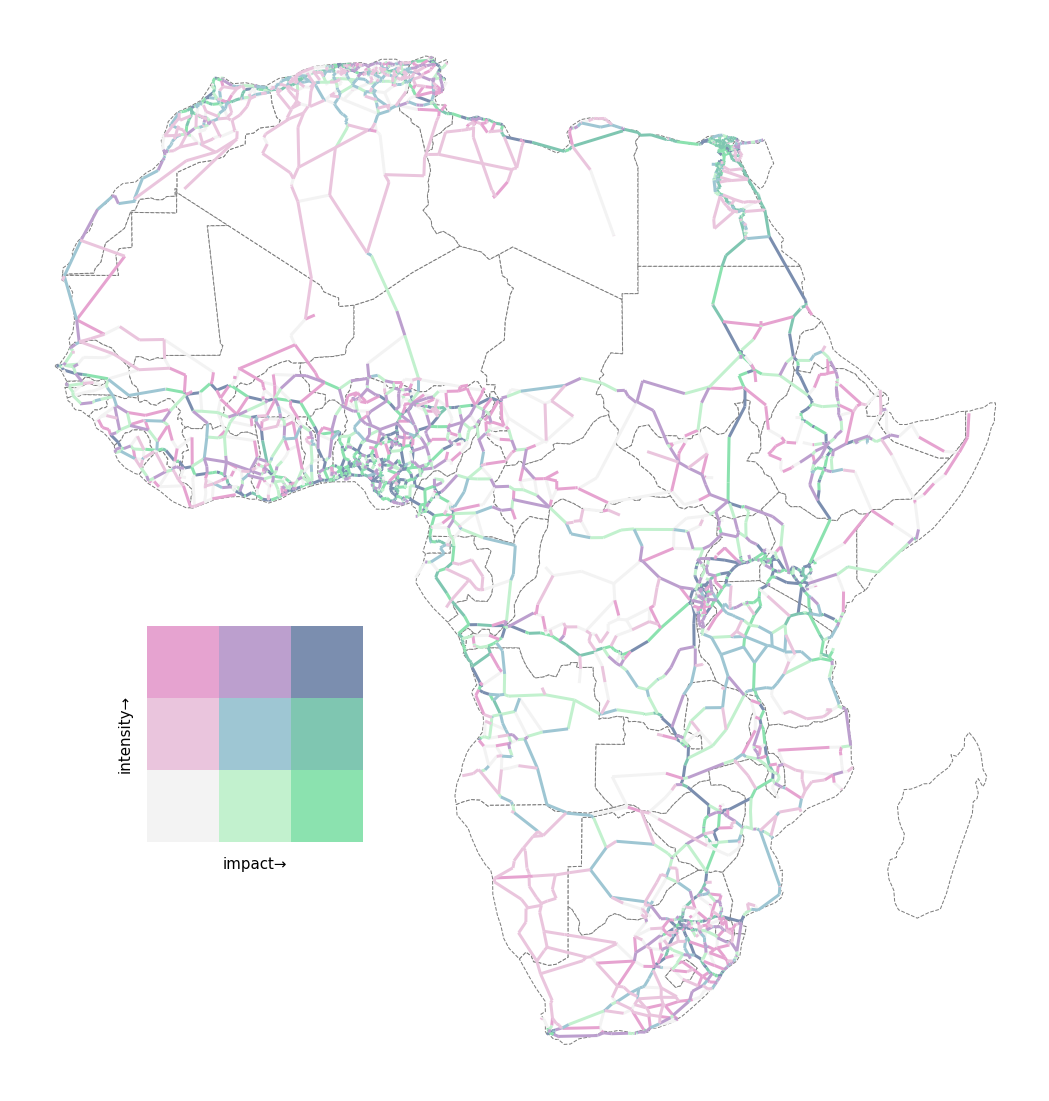

In [129]:
colours = {
    "class": ["1-1", "2-1", "3-1", "1-2", "2-2", "3-2", "1-3", "2-3", "3-3"], 
    "color": ["#f3f3f3", "#c2f1ce", "#8be2af", "#eac5dd", "#9ec6d3", "#7fc6b1", "#e6a3d0", "#bc9fce", "#7b8eaf"]
}

params = {'title': '', 'label1': 'impact', 'label2': 'intensity', 'lwd': 3, 'fnm': '../viz/africapolis-riskvflow-white-edges.png'}
bivariate_choropleth(joined, africa, "flow", "risk", scheme=colours, background='w', **params)

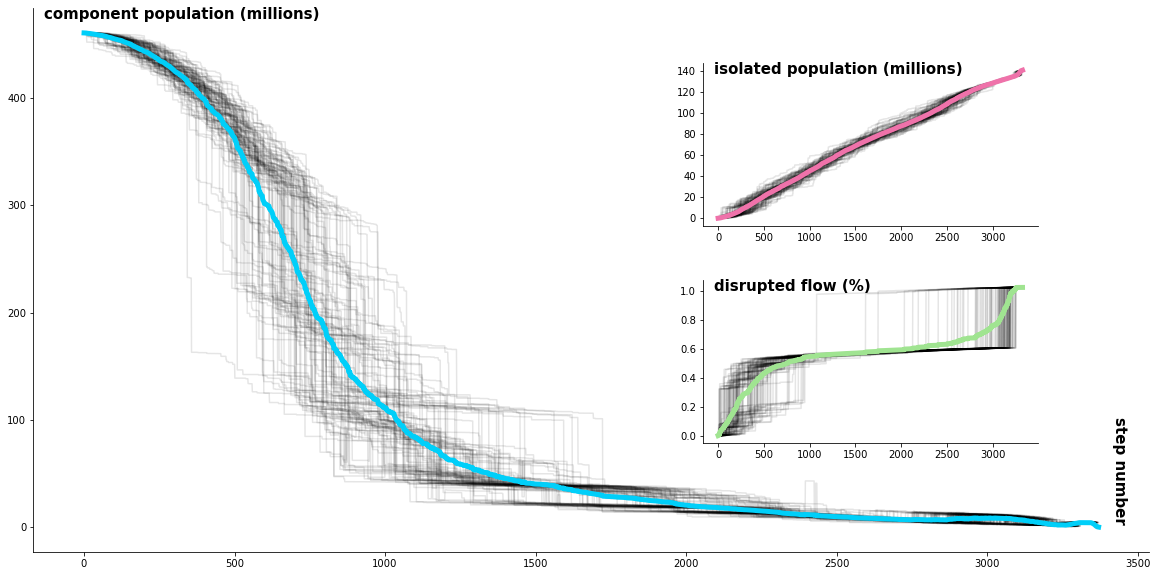

In [256]:
# copy the lengths dictionary
component_dict_ = component_dict.copy()

# get the maximum component population of all lists in the dict
max_component = max([len(i) for i in component_dict_.values()])

# pad each entry with 0 to the length of the longest list
for i in component_dict_.keys():
    component_dict_[i] = np.pad(component_dict_[i], (0, max_component-len(component_dict_[i])), 'constant')

# copy the lengths dictionary
stranded_dict_ = stranded_dict.copy()

# get the maximum stranded people of all lists in the dict
max_stranded = max([len(i) for i in stranded_dict_.values()])

# pad each entry with 0 to the length of the longest list
for i in stranded_dict_.keys():
    stranded_dict_[i] = np.pad(stranded_dict_[i], (0, max_stranded-len(stranded_dict_[i])), 'edge')

# plot the damage over time
fig, ax = plt.subplots(figsize=(20, 10), facecolor='w')
for i in component_dict.keys():
    ax.plot(component_dict[i], color='k', alpha=0.1)

ax.plot(np.mean(list(component_dict_.values()), axis=0), color=crosswalk.color.iloc[3], linewidth=5)
# ax.set_title('component population', size=20, weight='bold')

# build an inset plot with the isolates
axins_1 = ax.inset_axes([0.6, 0.6, 0.3, 0.3])
for i in stranded_dict_.keys():
    axins_1.plot(stranded_dict_[i][:-45], color='k', alpha=0.1)

axins_1.plot(np.mean(list(stranded_dict_.values()), axis=0)[:-45], color=crosswalk.color.iloc[2], linewidth=5)
# axins_1.set_title('isolated population', size=20, weight='bold')

axins_2 = ax.inset_axes([0.6, 0.2, 0.3, 0.3])
for i in stranded_dict_.keys():
    axins_2.plot(damage_dict_[i][:-45], color='k', alpha=0.1)

axins_2.plot(np.mean(list(damage_dict_.values()), axis=0)[:-45], color=crosswalk.color.iloc[0], linewidth=5)
# axins_2.set_title('disrupted flow (%)', size=20, weight='bold')

# remove scientific notation, use commas instead
ax.ticklabel_format(style='plain')

axins_1.ticklabel_format(style='plain')
axins_2.ticklabel_format(style='plain')

# import ticker
import matplotlib.ticker as ticker

# divide axis labels by 1000
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/10**6)))

axins_1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/10**6)))
# axins_2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/10**6)))

# add text to show that the tick labels are in millions
ax.text(0.01, 0.98, 'component population (millions)', transform=ax.transAxes, size=15, weight='bold')
# add text to lower right turned 90 degrees
ax.text(0.98, 0.05, 'step number', transform=ax.transAxes, size=15, weight='bold', ha='right', va='bottom', rotation=270)

axins_1.text(0.61, 0.88, 'isolated population (millions)', transform=ax.transAxes, size=15, weight='bold')
axins_2.text(0.61, 0.48, 'disrupted flow (%)', transform=ax.transAxes, size=15, weight='bold')

# show horizontal gridlines
# ax.grid(axis='y')

# remove vertical splines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)

# add horizontal gridlines to subplot
# axins_1.grid(axis='y')
# axins_2.grid(axis='y')

# remove vertical splines
axins_1.spines['right'].set_visible(False)
axins_1.spines['top'].set_visible(False)
# axins_1.spines['left'].set_visible(False)

axins_2.spines['right'].set_visible(False)
axins_2.spines['top'].set_visible(False)
# axins_2.spines['left'].set_visible(False)

# set the limits of the inset plot to be 45 less on the x-axis
# axins.set_xlim(0, 1455)

# make the whole subplot transparent
axins_1.patch.set_alpha(0.9)

# save the figure
fig.savefig('../viz/africapolis-all-monte-carlo.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')